# Analysis of Power Consumption of Scientific Computing Applicationsin Multicore Architectures

### Characterization, Modeling and Scheduling of Operational Power Consumption in Data centers, considering Scientific Computing Applications





> The present notebook includes and describes python scripts using the pandas and numpy libraries, for the processing and analysis of the log data generated in the experiments of characterization of power consumption in multicores



## Index
* 1 Introduction
* 2 Description
* 3 Data proccessing
* 4 Data visualization
* 5 Data modeling
* 6 Conclusion





In [1]:
from IPython.display import Image
import pandas as pd
from os import walk
%pylab inline
import re
import matplotlib.pyplot as plt
plt.rc('legend', fontsize='small')
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML
from datetime import timedelta
from __future__ import print_function, division
import statsmodels.formula.api as smf
import pylab as pl

pd.set_option('precision', 2)

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import scipy


Populating the interactive namespace from numpy and matplotlib


## 1 Introduction

### MOTIVATION

This work aims to enhance the data processing of my thesis as well as generating a jupyter notebook with clear exposure of the results.

## 2 Description


One of the activities of the thesis is collecting information of power consumption of computers (hosts) while benchmarks are executed. The goal is the characterization of power consumption regarding of computing resource type utilized and the utilization level, this is, the used percentage of the host capacity.

The following infrastructure is used: 

![alt text](milab_files/images/setup.png "Monitoring setup")


Benchmarks are executed in host while a script is polling the power meter (PDU) and logging the consumption information. There are three types of benchmarks each one oriented to a particular computational resource (CPU, memory or disk).
The benchmarks are executed individually and combined, and also with different utilization levels.

An experiment consists of one or several types of benchmarks, executing, at a certain utilization level. For example, the experiment "c1l37y5" corresponds to the CPU-bound benchmark running with a utilization level of 35.5% and the experiment "c1f1l2525" corresponds to the CPU-bound benchmark running combined with the disk-bound benchmark, both with a utilization level of 25%.

Each experiments is executed 20 times for statistical validity.

### DEFINITIONS

- Overall Power Consumption: is the power consumption measured by the power meter while a benchmark is running
- Idle Power Consumption: is the power consumption of the host without workload
- Effective PowerConsumptoin: is the Overall Power COnsumption less the Idle Power Consumption.



***

## 3 Data proccessing 

### DATA SOURCES


There are two data sources to process. On the one hand the power consumption (written in logging machine) and on the other the start and end of the benchmarks executions (written in host). By comparing the datetime of both sources, it is possible to know how much energy the execution of a process consumed.

#### Source 1: Power log

This information is registered polling every one second on the power meter and registering the instant power measured in a text file. 
In the following code lines the logs of each day are concatenated in the same dataframe (cleanDfEnergyLog).
The relevant fields are "datetime" and instant power "P(W)". The format of power log files is the following:

    |datetime|Timestamp (local to the python script)|I(amps)|P(W)|F(mm/dd/aaaa)|H(hh/mm/ss)|Device Load (amps)|Bank 1 Load (amps)|Bank 2 Load (amps)|P(W/VA)|Power factor|Peak Load(W)|Fecha del Peak Load|Hora del Peak Load|E(KWh)|Fecha desde que se cuenta E|Hora desde que se cuenta E|Voltaje(V)|Frecuencia(Hz)|
    |2016-08-30 00:00:00|1472526000.47|0.84|182|08/30/2016|02:54:37|0.84|0.84|0.00|182/192|0.947|1.82|02/07/2016|16:08:39|1120.5|12/16/2015|12:08:30|229.0|50.0|
    |2016-08-30 00:00:01|1472526001.65|0.85|183|08/30/2016|02:54:38|0.85|0.85|0.00|183/195|0.938|1.82|02/07/2016|16:08:39|1120.5|12/16/2015|12:08:30|229.0|50.0|



In [2]:
#Collecting power log files from disk
POW_DIR = "milab_files/energy_logs/"
list_of_file_names= next(walk(POW_DIR))[2]
dfEnergyLog = pd.DataFrame()
for file_name in list_of_file_names[:]:
    dfEnergyLogAux=pd.read_csv(POW_DIR + file_name, sep='|',dtype=np.str)
    dfEnergyLog = dfEnergyLog.append(dfEnergyLogAux)

#Cleaning (deleting rows without date format, that is: headers, broken lines)
r = re.compile('([0-9]{4}-[0-9]{2}-[0-9]{2} [0-9]{2}:[0-9]{2}:[0-9]{2})')


dfEnergyLog.datetime = dfEnergyLog.datetime.astype(str)

df=dfEnergyLog
cleanDfEnergyLog = df[df.datetime.str.match(r)][['datetime','P(W)']]
#Converting to appropriate types
cleanDfEnergyLog['datetime'] =  pd.to_datetime(cleanDfEnergyLog['datetime'][:]
                                            , format='%Y-%m-%d %H:%M:%S')
cleanDfEnergyLog['P(W)'] = pd.to_numeric(cleanDfEnergyLog['P(W)'])

#Showing result
cleanDfEnergyLog[['datetime','P(W)']].head()


,datetime,P(W)
0,2016-09-08 00:00:00,186
1,2016-09-08 00:00:01,184
2,2016-09-08 00:00:02,184
3,2016-09-08 00:00:03,184
4,2016-09-08 00:00:05,184


#### Source 2: Executions logs

When a benchmark execution begins or ends, an empty text file is created. The filename contains the info: 

- Experiment id: It resumes the benchmark used (CPU, memory o disk), the modality (single o combined) and the utilization level (12.5%, 25%, ...).
- Execution id: It is an identification for the particular run.
- Datetime: Timestamp of the file creation
- Begin or end flag: It indicates if is the begining or the end of the execution


The format of execution log filemanes is the following:

   c1f1l2525_20160912235624996_2016|09|12-23:56:25:001.ini


In the following lines of code the execution logs are collected and grouped by modality-host in dataframes. Each line of the dataframes corresponds to one benchmark execution (it indicates the start and the end)

In [3]:

#Collecting execution logs files from disk
def collectExecutionLogs(EXE_DIR):

    list_of_file_names= next(walk(EXE_DIR))[2]
    df_exe = pd.DataFrame(list_of_file_names)

    #Separating the name of the file in columns by split 
    df_exe.columns = ['data']
    df_exe = pd.DataFrame(df_exe.data.str.split('_').tolist(), columns = ['cod','run','data'])
    df_exe_aux = pd.DataFrame(df_exe.data.str.split('.').tolist(), columns = ['datetime','inifin'])
    df_exe['inifin'] = df_exe_aux['inifin']
    
    #Truncating milliseconds, they are unnecessary
    df_exe['datetime'] = df_exe_aux['datetime'].str.slice(0,-4)
     
    #Converting to appropriate types
    df_exe['datetime'] =  pd.to_datetime(df_exe['datetime'][:]
                                                 , format='%Y|%m|%d-%H:%M:%S')
    #merging and filtering to get one execution per row
    df_exe_merged = pd.merge(df_exe, df_exe, on='run')[['cod_x','run','datetime_x','inifin_x','datetime_y','inifin_y']]
    df_exe_filtered = df_exe_merged[df_exe_merged.inifin_x=='ini'][df_exe_merged.inifin_y=='end']
    return df_exe_filtered


df_exe_energy_single_intel = collectExecutionLogs("milab_files/executions/energy/single/intel");
df_exe_energy_single_amd = collectExecutionLogs("milab_files/executions/energy/single/amd");

df_exe_energy_double_intel = collectExecutionLogs("milab_files/executions/energy/double/intel");
df_exe_energy_double_amd = collectExecutionLogs("milab_files/executions/energy/double/amd");

df_exe_energy_triple_intel = collectExecutionLogs("milab_files/executions/energy/triple/intel");
df_exe_energy_triple_amd = collectExecutionLogs("milab_files/executions/energy/triple/amd");

#Showing result example
df_exe_energy_triple_amd.head()

/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,cod_x,run,datetime_x,inifin_x,datetime_y,inifin_y
1,c1m2f1l252550,20161031052009429,2016-10-31 05:20:09,ini,2016-10-31 05:21:11,end
6,c1m2f1l502525,20161031070907407,2016-10-31 07:09:07,ini,2016-10-31 07:10:09,end
10,c1m2f1l252525,20161031021209690,2016-10-31 02:12:09,ini,2016-10-31 02:13:11,end
14,c1m2f1l252550,20161031060828925,2016-10-31 06:08:28,ini,2016-10-31 06:09:45,end
18,c1m2f1l502525,20161031065100152,2016-10-31 06:51:00,ini,2016-10-31 06:52:02,end


#### REQUIRED PRE-PROCCESING

Over the dataframes of the benchmark execution it is neccesary to execute the following operations to facilitate the visualization and analysis:

- Transforming "experiment cod" to "benchmark cod" and "utilization level"
- Adding offset of seconds between host and logging machine
- Also, assigning variables with IDLE power consumption (this experiment is not included in this work)

In the following segments of code this operations are executed:

In [4]:
#experiment cod to benchmark code
def cod2bkcod(cod):
  if 'c1m2f1' in cod:
        return 'c1m2f1'
  if 'c1m2' in cod:
        return 'c1m2'
  if 'm2f1' in cod:
        return 'm2f1'
  if 'c1f1' in cod:
        return 'c1f1'
  if 'm2' in cod:
        return 'm2'
  if "c1" in cod:
        return 'c1'
  if "f1" in cod:
        return 'f1'

#experiment cod to utilization level. First coordinate
def cod2ULx(cod):
    
  if "252525" in cod:
        return 25
  if "252550" in cod:
        return 25
  if "255025" in cod:
        return 25
  if "502525" in cod:
        return 50  
      
    
  if "2525" in cod:
        return 25
  if "2550" in cod:
        return 25
  if "2575" in cod:
        return 25
  if "5025" in cod:
        return 50
  if "5050" in cod:
        return 50
  if "7525" in cod:
        return 75
  
  if '12y5' in cod:
        return 12.5
  if "25" in cod:
        return 25
  if "37y5" in cod:
        return 37.5
  if "50" in cod:
        return 50
  if "62y5" in cod:
        return 62.5
  if "75" in cod:
        return 75
  if "87y5" in cod:
        return 87.5
  if "100" in cod:
        return 100
      
        
#experiment cod to utilization level. Second coordinate 
def cod2ULy(cod):
  if "252525" in cod:
        return 25
  if "252550" in cod:
        return 25
  if "255025" in cod:
        return 50
  if "502525" in cod:
        return 25
    
  if "2525" in cod:
        return 25
  if "2550" in cod:
        return 50
  if "2575" in cod:
        return 75
  if "5025" in cod:
        return 25
  if "5050" in cod:
        return 50
  if "7525" in cod:
        return 25

#experiment cod to utilization level. Thrid coordinate 
def cod2ULz(cod):    
  if "252525" in cod:
        return 25
  if "252550" in cod:
        return 50
  if "255025" in cod:
        return 25
  if "502525" in cod:
        return 25
    
#experiment cod to utilization level and benchmark cod. Single modality
def singleULAndBkCod(df_exe):
    df_exe['UL'] =  df_exe.apply(lambda x:cod2ULx(x.cod_x),axis = 1) 
    df_exe['bkcod'] =  df_exe.apply(lambda x:cod2bkcod(x.cod_x),axis = 1) 
    return df_exe

#experiment cod to utilization level and benchmark cod. Double modality
def doubleULAndBkCod(df_exe):
    df_exe['ULx'] =  df_exe.apply(lambda x:cod2ULx(x.cod_x),axis = 1) 
    df_exe['ULy'] =  df_exe.apply(lambda x:cod2ULy(x.cod_x),axis = 1) 
    df_exe['bkcod'] =  df_exe.apply(lambda x:cod2bkcod(x.cod_x),axis = 1) 
    return df_exe

#experiment cod to utilization level and benchmark cod. Triple modality
def tripleULAndBkCod(df_exe):
    df_exe['ULx'] =  df_exe.apply(lambda x:cod2ULx(x.cod_x),axis = 1) 
    df_exe['ULy'] =  df_exe.apply(lambda x:cod2ULy(x.cod_x),axis = 1) 
    df_exe['ULz'] =  df_exe.apply(lambda x:cod2ULz(x.cod_x),axis = 1)     
    df_exe['bkcod'] =  df_exe.apply(lambda x:cod2bkcod(x.cod_x),axis = 1) 
    return df_exe

df_exe_energy_single_intel = singleULAndBkCod(df_exe_energy_single_intel)
df_exe_energy_single_amd = singleULAndBkCod(df_exe_energy_single_amd)

df_exe_energy_double_intel = doubleULAndBkCod(df_exe_energy_double_intel)
df_exe_energy_double_amd = doubleULAndBkCod(df_exe_energy_double_amd)

df_exe_energy_triple_intel = tripleULAndBkCod(df_exe_energy_triple_intel)
df_exe_energy_triple_amd = tripleULAndBkCod(df_exe_energy_triple_amd)

#TODO
AMD_IDLE_PC = 183.4
INTEL_IDLE_PC = 57.0


The difference in the system time between host and logging machine was registered in each experiment. In the following lines of code, begin and end times of the experiments are fixed with the corresponding offset 

In [5]:
# adding offset to begin and end time off the benchmark execution
def addOffset(df_exe,offsetSeconds):
    df_exe.datetime_y = \
    df_exe.apply(lambda x: pd.to_datetime(x.datetime_y)+pd.Timedelta(seconds=offsetSeconds) ,axis = 1)
    df_exe.datetime_x = \
    df_exe.apply(lambda x: pd.to_datetime(x.datetime_x)+pd.Timedelta(seconds=offsetSeconds) ,axis = 1)
    return df_exe
    
offsetSeconds = -10810
df_exe_energy_single_intel = addOffset(df_exe_energy_single_intel,offsetSeconds)

offsetSeconds = -11036
df_exe_energy_single_amd = addOffset(df_exe_energy_single_amd,offsetSeconds)

offsetSeconds = -180
df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1m2'] = \
addOffset(df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1m2'],offsetSeconds)

offsetSeconds = -10810
df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1f1'] = \
addOffset(df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1f1'],offsetSeconds)
df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='m2f1'] = \
addOffset(df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='m2f1'],offsetSeconds)

offsetSeconds = -11036
df_exe_energy_double_amd = \
addOffset(df_exe_energy_double_amd,offsetSeconds)

offsetSeconds = -10810
df_exe_energy_triple_intel = \
addOffset(df_exe_energy_triple_intel,offsetSeconds)

offsetSeconds = -180
df_exe_energy_triple_amd = \
addOffset(df_exe_energy_triple_amd,offsetSeconds)


/home/jon/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



### DATA CROSSING

After collecting data from each source, it is neccesary to cross the information to get the power consumption of the benchmark executions. For each experiment, that corresponds to the combination benchmark-modality-utilization level, there are 20  independent executions. The result of the following code are dataframes grouped by modality and host. The rows are the benchmark executions and their power consumption (caculated as the average of the power registered in the logging machine whlie the benchmark is executing)  

In [9]:
#add new column "power_average" that is the average 
#of power registered between the begins and the end of an execution
def crossing(df_exe):
    power_average = []
    #power_desv = []
    for index, row in df_exe.iterrows():
      cleanDfEnergyLogCropSup = cleanDfEnergyLog[row.datetime_y > cleanDfEnergyLog.datetime]
      cleanDfEnergyLogCropInfAndSup = cleanDfEnergyLogCropSup[row.datetime_x < cleanDfEnergyLogCropSup.datetime]
      aux_mean = cleanDfEnergyLogCropInfAndSup['P(W)'].mean()      
      #aux_std = cleanDfEnergyLogCropInfAndSup['P(W)'].std() 
      if aux_mean == 0:
            print ("there is a zero")
      power_average.append(aux_mean)
      #power_desv.append(aux_std)

    df_exe['power_average'] = pd.Series(power_average).values
    return df_exe

#applying for each modality-host
df_exe_energy_single_intel=crossing(df_exe_energy_single_intel)
df_exe_energy_single_amd=crossing(df_exe_energy_single_amd)
df_exe_energy_double_intel=crossing(df_exe_energy_double_intel)
df_exe_energy_double_amd=crossing(df_exe_energy_double_amd)
df_exe_energy_triple_intel=crossing(df_exe_energy_triple_intel)
df_exe_energy_triple_amd=crossing(df_exe_energy_triple_amd)

#showing result for experiment 'c1l100' as example. the 20 independent executions
display(df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l100'])
#display(df_exe_energy_single_amd)





,cod_x,run,datetime_x,inifin_x,datetime_y,inifin_y,UL,bkcod,power_average
49,c1l100,20160831070335180,2016-08-31 03:59:39,ini,2016-08-31 04:00:41,end,100.0,c1,263.0
117,c1l100,20160831071145268,2016-08-31 04:07:49,ini,2016-08-31 04:08:51,end,100.0,c1,263.2
250,c1l100,20160831072157971,2016-08-31 04:18:01,ini,2016-08-31 04:19:04,end,100.0,c1,264.1
321,c1l100,20160831070132666,2016-08-31 03:57:36,ini,2016-08-31 03:58:39,end,100.0,c1,266.1
357,c1l100,20160831072603041,2016-08-31 04:22:07,ini,2016-08-31 04:23:09,end,100.0,c1,267.8
398,c1l100,20160831071550321,2016-08-31 04:11:54,ini,2016-08-31 04:12:56,end,100.0,c1,268.0
449,c1l100,20160831072805567,2016-08-31 04:24:09,ini,2016-08-31 04:25:12,end,100.0,c1,264.4
510,c1l100,20160831070942732,2016-08-31 04:05:46,ini,2016-08-31 04:06:49,end,100.0,c1,262.5
538,c1l100,20160831065727634,2016-08-31 03:53:31,ini,2016-08-31 03:54:34,end,100.0,c1,263.0
693,c1l100,20160831070537688,2016-08-31 04:01:41,ini,2016-08-31 04:02:44,end,100.0,c1,261.4


### PERFORMANCE EXECUTIONS

For complementing the power characterization, performance experiments are executed. In this experiments the same benchmarks, without time limit, are runnnig in different utilization levels. This procedure allows to determine how workload affects the performance for each type of benchmark. Only single modality is considered. 

In this case, the filename contains the info: 

- Experiment id: It resumes the benchmark used (CPU, memory o disk), the modality (single o combined) and the utilization level (12.5%, 25%, ...).
- Execution id: It is an identification of the particular run.
- Proccess id: It is an identification of one benchmark instance in the execution
- Datetime: Timestamp of the file creation
- Begin or end flag: It indicates if is the begining or the end of the execution


The format of execution log filemanes is the following:

    c1ntl12y5_20170302122631609_c1unt_20170302122631614_2017|03|02-12:26:31:620.ini

The following lines of code collect, clean, convert and merge the information of the performance execution. The result is dataframes grouped by host. The rows are the instances of the benchmark executions.  

In [10]:
#COllecting execution log files of performance experiments
def collectPerformanceExecutionLogs(EXE_DIR):

    list_of_file_names= next(walk(EXE_DIR))[2]
    df_exe = pd.DataFrame(list_of_file_names)

    #Separating the name of the file in columns by split 
    df_exe.columns = ['data']
    df_exe = pd.DataFrame(df_exe.data.str.split('_').tolist(), columns = ['cod','exe','codu','instance','data'])
    df_exe_aux = pd.DataFrame(df_exe.data.str.split('.').tolist(), columns = ['datetime','inifin'])

    #Truncating milliseconds, they are unnecessary
    df_exe['datetime'] = df_exe_aux['datetime'].str.slice(0,-4)
    df_exe['inifin'] = df_exe_aux['inifin'] 

    #Converting to appropriate types
    df_exe['datetime'] =  pd.to_datetime(df_exe['datetime'][:]
                                                 , format='%Y|%m|%d-%H:%M:%S')
    
    #Merging and filtering to get one execution per row
    df_exe_merged = pd.merge(df_exe, df_exe, on=['exe','instance','codu'])\
    [['cod_x','codu','exe','instance','datetime_x','inifin_x','cod_y','datetime_y','inifin_y']]
    df_exe_filtered = df_exe_merged[df_exe_merged.inifin_x=='ini'][df_exe_merged.inifin_y=='end']
    
    #Calcuating instances duration
    df_exe_filtered['time']=  df_exe_filtered['datetime_y'] - df_exe_filtered['datetime_x']
    df_exe_filtered['seconds']=   df_exe_filtered['time'].dt.total_seconds()
        
    return df_exe_filtered


df_exe_performance_single_amd = collectPerformanceExecutionLogs("milab_files/executions/performance/single/amd")
df_exe_performance_single_intel = collectPerformanceExecutionLogs("milab_files/executions/performance/single/intel")

#Obtaining utilization level 
df_exe_performance_single_amd = singleULAndBkCod(df_exe_performance_single_amd)
df_exe_performance_single_intel = singleULAndBkCod(df_exe_performance_single_intel)

#Showing result example
df_exe_performance_single_intel.head()


/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,cod_x,codu,exe,instance,datetime_x,inifin_x,cod_y,datetime_y,inifin_y,time,seconds,UL,bkcod
1,m2ntl100,m2unt,20170302191600598,20170302191602128,2017-03-02 19:16:02,ini,m2ntl100,2017-03-02 19:17:20,end,00:01:18,78.0,100.0,m2
6,f1ntl100,f1unt,20170304053230771,20170304053230979,2017-03-04 05:32:30,ini,f1ntl100,2017-03-04 05:35:14,end,00:02:44,164.0,100.0,f1
12,m2ntl87y5,m2unt,20170302181613817,20170302181615425,2017-03-02 18:16:15,ini,m2ntl87y5,2017-03-02 18:17:21,end,00:01:06,66.0,87.5,m2
15,m2ntl87y5,m2unt,20170302181613817,20170302181615425,2017-03-02 18:16:15,ini,m2ntl87y5,2017-03-02 18:17:21,end,00:01:06,66.0,87.5,m2
16,m2ntl87y5,m2unt,20170302181613817,20170302181615425,2017-03-02 18:16:15,ini,m2ntl87y5,2017-03-02 18:17:21,end,00:01:06,66.0,87.5,m2


## 4 Data Visualization

### POWER CONSUMPTION. SIMPLE EXECUTIONS

The following code shows the power consumption of single executions, for both host. 

,UL,AMD cpu,AMD cpu EC,AMD memory,AMD memory EC,AMD disk,AMD disk EC,Intel cpu,Intel cpu EC,Intel memory,Intel memory EC,Intel disk,Intel disk EC
0,12.5,194.4,11.0,215.5,32.1,188.1,4.7,121.6,64.6,125.9,68.9,67.5,10.5
1,25.0,205.0,21.6,238.7,55.3,189.3,5.9,136.6,79.6,156.3,99.3,68.0,11.0
2,37.5,215.1,31.7,257.7,74.3,189.5,6.1,142.5,85.5,178.7,121.7,67.7,10.7
3,50.0,225.1,41.7,272.3,88.9,189.3,5.9,152.8,95.8,191.8,134.8,68.9,11.9
4,62.5,235.5,52.1,278.5,95.1,189.9,6.5,163.2,106.2,213.0,156.0,70.5,13.5
5,75.0,246.0,62.6,279.9,96.5,190.1,6.7,175.8,118.8,225.0,168.0,70.7,13.7
6,87.5,254.7,71.3,290.8,107.4,190.7,7.3,185.8,128.8,239.2,182.2,71.7,14.7
7,100.0,264.1,80.7,294.7,111.3,190.4,7.0,194.6,137.6,249.0,192.0,72.4,15.4


'Energy-simple-AMD'

/home/jon/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



Text(0,0.5,'Power (W)')

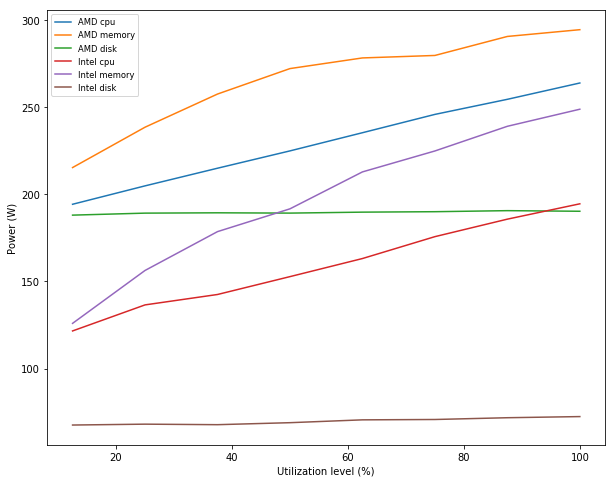

In [11]:
#bla = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='c1']
#display( bla[bla['cod_x']=='c1l25'] )

pd.set_option('precision', 1)

df_exe_energy_single_amd_c1_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='c1']\
         .groupby(['UL']).mean().reset_index()

df_exe_energy_single_amd_m2_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='m2']\
         .groupby('UL').mean().reset_index()

df_exe_energy_single_amd_f1_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='f1']\
         .groupby('UL').mean().reset_index()

df_exe_energy_single_intel_c1_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='c1']\
         .groupby(['UL']).mean().reset_index()
    
df_exe_energy_single_intel_m2_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='m2']\
         .groupby('UL').mean().reset_index()

df_exe_energy_single_intel_f1_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='f1']\
         .groupby('UL').mean().reset_index()    
   

df_result = pd.concat([
                    df_exe_energy_single_amd_c1_pw,\
                    df_exe_energy_single_amd_c1_pw['power_average']-AMD_IDLE_PC,\
                    df_exe_energy_single_amd_m2_pw['power_average'],\
                    df_exe_energy_single_amd_m2_pw['power_average']-AMD_IDLE_PC,\
                    df_exe_energy_single_amd_f1_pw['power_average'],\
                    df_exe_energy_single_amd_f1_pw['power_average']-AMD_IDLE_PC,\
                    df_exe_energy_single_intel_c1_pw['power_average'],\
                    df_exe_energy_single_intel_c1_pw['power_average']-INTEL_IDLE_PC,\
                    df_exe_energy_single_intel_m2_pw['power_average'],\
                    df_exe_energy_single_intel_m2_pw['power_average']-INTEL_IDLE_PC,\
                    df_exe_energy_single_intel_f1_pw['power_average'],\
                    df_exe_energy_single_intel_f1_pw['power_average']-INTEL_IDLE_PC\
                    ],\
                  axis=1)    

df_result.columns = ['UL', 
                     'AMD cpu',
                     'AMD cpu EC',
                     'AMD memory',
                     'AMD memory EC',
                     'AMD disk',
                     'AMD disk EC' ,
                     'Intel cpu', 
                     'Intel cpu EC', 
                     'Intel memory',
                     'Intel memory EC',
                     'Intel disk',
                     'Intel disk EC'
                    
                    ]


display (df_result,'Energy-simple-AMD')


aux = df_result.plot(x='UL', y=['AMD cpu', 'AMD memory','AMD disk', 'Intel cpu', 'Intel memory','Intel disk'],\
                     figsize=(10, 8)
                    )

aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Power (W)")

### POWER CONSUMPTION. DOBLE EXECUTIONS

The following code shows the power consumption of combined executions (in pairs) for both host. 


,ULx,ULy,AMD cpu mem,AMD cpu mem EC,AMD cpu disk,AMD cpu disk EC,AMD mem disk,AMD mem disk EC,Intel cpu mem,Intel cpu mem EC,Intel cpu disk,Intel cpu disk EC,Intel mem disk,Intel mem disk EC
0,25,25,259.4,76.0,210.0,26.6,243.9,60.5,264.1,207.1,136.4,79.4,174.1,117.1
1,25,50,290.3,106.9,211.5,28.1,241.8,58.4,296.5,239.5,139.0,82.0,176.2,119.2
2,25,75,312.7,129.3,212.4,29.0,245.9,62.5,325.6,268.6,137.2,80.2,172.0,115.0
3,50,25,277.1,93.7,229.8,46.4,268.2,84.8,279.1,222.1,154.2,97.2,206.4,149.4
4,50,50,310.3,126.9,234.3,50.9,269.5,86.1,320.4,263.4,156.5,99.5,208.6,151.6
5,75,25,295.8,112.4,248.4,65.0,287.0,103.6,302.3,245.3,177.8,120.8,228.5,171.5


'Energy-double'

/home/jon/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



Text(0,0.5,'Power (W)')

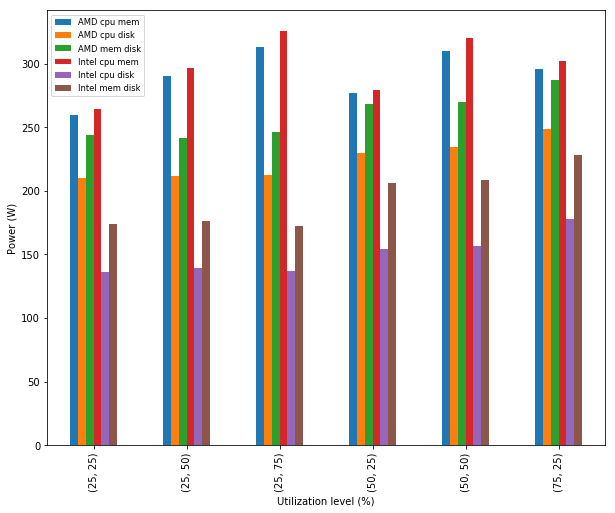

In [12]:
df_exe_energy_double_amd_pw_c1m2 = df_exe_energy_double_amd[df_exe_energy_double_amd['bkcod']=='c1m2']\
         .groupby(['ULx','ULy']).mean().reset_index()
df_exe_energy_double_amd_pw_c1f1 = df_exe_energy_double_amd[df_exe_energy_double_amd['bkcod']=='c1f1']\
         .groupby(['ULx','ULy']).mean().reset_index()
df_exe_energy_double_amd_pw_m2f1 = df_exe_energy_double_amd[df_exe_energy_double_amd['bkcod']=='m2f1']\
         .groupby(['ULx','ULy']).mean().reset_index()    

df_exe_energy_double_intel_pw_c1m2 = df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1m2']\
         .groupby(['ULx','ULy']).mean().reset_index()
df_exe_energy_double_intel_pw_c1f1 = df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1f1']\
         .groupby(['ULx','ULy']).mean().reset_index()
df_exe_energy_double_intel_pw_m2f1 = df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='m2f1']\
         .groupby(['ULx','ULy']).mean().reset_index()
   
df_result = pd.concat([\
                    df_exe_energy_double_amd_pw_c1m2,\
                    df_exe_energy_double_amd_pw_c1m2['power_average']-AMD_IDLE_PC,\
                    df_exe_energy_double_amd_pw_c1f1['power_average'],\
                    df_exe_energy_double_amd_pw_c1f1['power_average']-AMD_IDLE_PC,\
                    df_exe_energy_double_amd_pw_m2f1['power_average'],\
                    df_exe_energy_double_amd_pw_m2f1['power_average']-AMD_IDLE_PC,\
                    
                       
                    df_exe_energy_double_intel_pw_c1m2['power_average'],\
                    df_exe_energy_double_intel_pw_c1m2['power_average']-INTEL_IDLE_PC,\
                    df_exe_energy_double_intel_pw_c1f1['power_average'],\
                    df_exe_energy_double_intel_pw_c1f1['power_average']-INTEL_IDLE_PC,\
                                           
                    df_exe_energy_double_intel_pw_m2f1['power_average'],\
                       df_exe_energy_double_intel_pw_m2f1['power_average']-INTEL_IDLE_PC\
                   ],axis=1)    
    

df_result.columns = ['ULx', 
                     'ULy', 
                    'AMD cpu mem',
                     'AMD cpu mem EC',
                     'AMD cpu disk',
                     'AMD cpu disk EC', 
                     'AMD mem disk',
                     'AMD mem disk EC',                     
                     'Intel cpu mem',
                     'Intel cpu mem EC',                     
                     'Intel cpu disk',
                     'Intel cpu disk EC',                     
                     'Intel mem disk',
                     'Intel mem disk EC']

display (df_result,'Energy-double')
aux = df_result.plot(x= ['ULx','ULy'],y=['AMD cpu mem', 'AMD cpu disk', 'AMD mem disk',\
                  'Intel cpu mem', 'Intel cpu disk', 'Intel mem disk'],kind='bar', figsize=(10, 8))


aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Power (W)")


### POWER CONSUMPTION. TRIPLE EXECUTIONS
 

The following code shows the power consumption of combined executions (in three) for both host. 


### deviation

,ULx,ULy,ULz,AMD cpu mem disk,AMD cpu mem disk EC,Intel cpu mem disk,Intel cpu mem disk EC
0,25,25,25,266.3,82.9,177.4,120.4
1,25,25,50,266.9,83.5,178.7,121.7
2,25,50,25,303.2,119.8,220.9,163.9
3,50,25,25,288.1,104.7,195.0,138.0


'Energy-CPU-Memory-Disk-triple'

/home/jon/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



Text(0,0.5,'Power (W)')

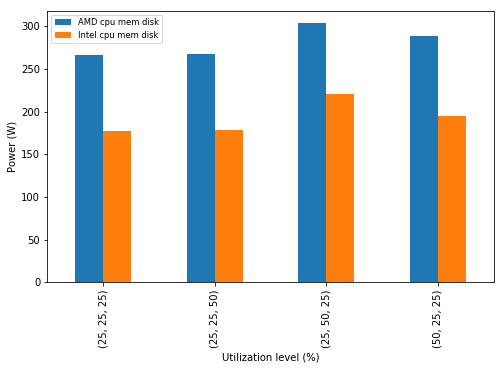

In [13]:
df_exe_energy_triple_amd_pw_c1m2f1 = df_exe_energy_triple_amd[df_exe_energy_triple_amd['bkcod']=='c1m2f1']\
.groupby(['ULx','ULy','ULz']).mean().reset_index()

df_exe_energy_triple_intel_pw_c1m2f1 = df_exe_energy_triple_intel[df_exe_energy_triple_intel['bkcod']=='c1m2f1']\
.groupby(['ULx','ULy','ULz']).mean().reset_index()

df_result = pd.concat([\
                    df_exe_energy_triple_amd_pw_c1m2f1,
                    df_exe_energy_triple_amd_pw_c1m2f1['power_average']-AMD_IDLE_PC,
                       df_exe_energy_triple_intel_pw_c1m2f1['power_average'],\
                        df_exe_energy_triple_intel_pw_c1m2f1['power_average']-INTEL_IDLE_PC\
                    ],axis=1)    

df_result.columns = ['ULx', 'ULy', 'ULz', 
                     'AMD cpu mem disk',
                     'AMD cpu mem disk EC',
                     'Intel cpu mem disk',
                     'Intel cpu mem disk EC'
                    ]
display(df_result,'Energy-CPU-Memory-Disk-triple')
aux= df_result.plot(x= ['ULx','ULy','ULz'],y=['AMD cpu mem disk', 'Intel cpu mem disk'],kind='bar', figsize=(8, 5))

aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Power (W)")

,ULx,ULy,ULz,AMD cpu mem disk,Intel cpu mem disk
0,25,25,25,4.5,4.1
1,25,25,50,4.7,3.5
2,25,50,25,3.2,5.5
3,50,25,25,1.7,5.0


'Energy-CPU-Memory-Disk-triple'

/home/jon/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



Text(0,0.5,'Power (W)')

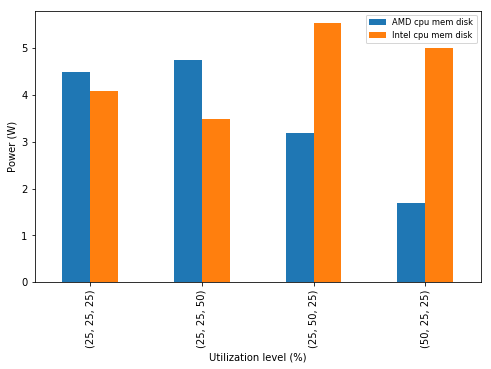

In [14]:
df_exe_energy_triple_amd_pw_c1m2f1 = df_exe_energy_triple_amd[df_exe_energy_triple_amd['bkcod']=='c1m2f1']\
.groupby(['ULx','ULy','ULz']).std().reset_index()

df_exe_energy_triple_intel_pw_c1m2f1 = df_exe_energy_triple_intel[df_exe_energy_triple_intel['bkcod']=='c1m2f1']\
.groupby(['ULx','ULy','ULz']).std().reset_index()

df_result = pd.concat([\
                    df_exe_energy_triple_amd_pw_c1m2f1,\
                    df_exe_energy_triple_intel_pw_c1m2f1['power_average'],\
                    ],axis=1)    

df_result.columns = ['ULx', 'ULy', 'ULz', 'AMD cpu mem disk', 'Intel cpu mem disk']
display(df_result,'Energy-CPU-Memory-Disk-triple')
aux= df_result.plot(x= ['ULx','ULy','ULz'],y=['AMD cpu mem disk', 'Intel cpu mem disk'],kind='bar', figsize=(8, 5))

aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Power (W)")

### PERFORMANCE. SINGLE EXECUTION
The following code shows the peformance of single executions for both host. 



,cod_x,codu,exe,instance,datetime_x,inifin_x,cod_y,datetime_y,inifin_y,time,seconds,UL,bkcod
10,f1ntl87y5,f1unt,20170207194619767,20170207194621197,2017-02-07 19:46:21,ini,f1ntl87y5,2017-02-07 20:24:19,end,00:37:58,2278.0,87.5,f1
1146,f1ntl87y5,f1unt,20170207194619767,20170207194619771,2017-02-07 19:46:19,ini,f1ntl87y5,2017-02-07 20:21:28,end,00:35:09,2109.0,87.5,f1
3110,f1ntl87y5,f1unt,20170207194619767,20170207194619872,2017-02-07 19:46:19,ini,f1ntl87y5,2017-02-07 20:24:19,end,00:38:00,2280.0,87.5,f1
3450,f1ntl87y5,f1unt,20170207194619767,20170207194621401,2017-02-07 19:46:21,ini,f1ntl87y5,2017-02-07 20:24:19,end,00:37:58,2278.0,87.5,f1
4206,f1ntl87y5,f1unt,20170207194619767,20170207194620177,2017-02-07 19:46:20,ini,f1ntl87y5,2017-02-07 20:19:37,end,00:33:17,1997.0,87.5,f1
6514,f1ntl87y5,f1unt,20170207194619767,20170207194620585,2017-02-07 19:46:20,ini,f1ntl87y5,2017-02-07 20:24:19,end,00:37:59,2279.0,87.5,f1
6609,f1ntl87y5,f1unt,20170207194619767,20170207194621808,2017-02-07 19:46:24,ini,f1ntl87y5,2017-02-07 20:20:09,end,00:33:45,2025.0,87.5,f1
7346,f1ntl87y5,f1unt,20170207194619767,20170207194620891,2017-02-07 19:46:20,ini,f1ntl87y5,2017-02-07 20:24:42,end,00:38:22,2302.0,87.5,f1
9598,f1ntl87y5,f1unt,20170207194619767,20170207194621299,2017-02-07 19:46:21,ini,f1ntl87y5,2017-02-07 20:24:19,end,00:37:58,2278.0,87.5,f1
10986,f1ntl87y5,f1unt,20170207194619767,20170207194619973,2017-02-07 19:46:19,ini,f1ntl87y5,2017-02-07 20:24:39,end,00:38:20,2300.0,87.5,f1


,UL,AMD cpu,AMD mem,AMD disk,Intel cpu,Intel mem,Intel disk
0,12.5,44.4,90.2,234.7,35.8,34.6,36.0
1,25.0,44.9,136.8,547.7,30.4,26.6,74.0
2,37.5,45.0,179.8,839.4,36.2,41.1,114.7
3,50.0,45.0,220.8,1397.8,30.8,41.8,154.5
4,62.5,45.0,259.1,1644.0,29.5,67.5,195.9
5,75.0,45.0,326.7,2006.3,29.9,62.2,239.0
6,87.5,45.0,408.2,2514.9,34.0,74.5,279.1
7,100.0,50.5,490.6,2571.5,47.4,82.5,313.6


'Performance-single'

/home/jon/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



Text(0,0.5,'Makespan (s)')

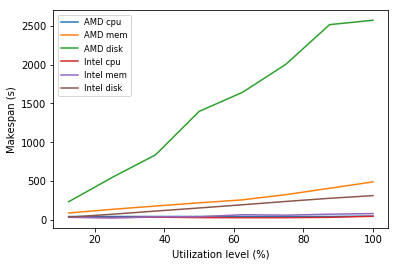

In [15]:

display(df_exe_performance_single_amd[df_exe_performance_single_amd['exe']=='20170207194619767'])

pd.set_option('precision', 1)
df_exe_performance_single_amd_pw_c1unt = df_exe_performance_single_amd[df_exe_performance_single_amd['codu']=='c1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).mean().reset_index()

df_exe_performance_single_amd_pw_m2unt = df_exe_performance_single_amd[df_exe_performance_single_amd['codu']=='m2unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).mean().reset_index()
    
df_exe_performance_single_amd_pw_f1unt = df_exe_performance_single_amd[df_exe_performance_single_amd['codu']=='f1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).mean().reset_index() 
    
df_exe_performance_single_intel_pw_c1unt = df_exe_performance_single_intel[df_exe_performance_single_intel['codu']=='c1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).mean().reset_index()

df_exe_performance_single_intel_pw_m2unt = df_exe_performance_single_intel[df_exe_performance_single_intel['codu']=='m2unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).mean().reset_index()
    
df_exe_performance_single_intel_pw_f1unt = df_exe_performance_single_intel[df_exe_performance_single_intel['codu']=='f1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).mean().reset_index()
    
    
df_result = pd.concat([df_exe_performance_single_amd_pw_c1unt,\
                    df_exe_performance_single_amd_pw_m2unt['seconds'],\
                    df_exe_performance_single_amd_pw_f1unt['seconds'],\
                   df_exe_performance_single_intel_pw_c1unt['seconds'],\
                    df_exe_performance_single_intel_pw_m2unt['seconds'],\
                    df_exe_performance_single_intel_pw_f1unt['seconds']],\
                  axis=1)    


df_result.columns = ['UL', 'AMD cpu', 'AMD mem', 'AMD disk', 'Intel cpu', 'Intel mem', 'Intel disk']
display (df_result,'Performance-single')

aux=df_result.plot(x= ['UL'],y=['AMD cpu', 'AMD mem', 'AMD disk', 'Intel cpu',\
                                         'Intel mem', 'Intel disk'])

aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Makespan (s)")



### EFFICIENCY

Efficiency metric is defined as $PC \times \;makespan \;/ \;3600 \;/\; number \;of\; instances$, where $PC$ is the Overall Power Consumption. The following code shows the metric for all benchmarks in both host. The more efficient level of utilization for each benchmark is highlighted.


In [16]:
pd.set_option('precision', 3)
df_result = pd.concat([df_exe_energy_single_amd_c1_pw['UL'],\
                       
                    df_exe_energy_single_amd_c1_pw['power_average']*\
                    df_exe_performance_single_amd_pw_c1unt['seconds']/\
                       (df_exe_energy_single_amd_c1_pw['UL']*3/12.5)/3600,\
                    
                       df_exe_energy_single_amd_m2_pw['power_average']*\
                    df_exe_performance_single_amd_pw_m2unt['seconds']/\
                       (df_exe_energy_single_amd_m2_pw['UL']*3/12.5)/3600,\
                       
                       df_exe_energy_single_amd_f1_pw['power_average']*\
                    df_exe_performance_single_amd_pw_f1unt['seconds']/\
                       (df_exe_energy_single_amd_f1_pw['UL']*3/12.5)/3600,\
                    
                    df_exe_energy_single_intel_c1_pw['power_average']*\
                    df_exe_performance_single_intel_pw_c1unt['seconds']/\
                       (df_exe_energy_single_intel_c1_pw['UL']*3/12.5)/3600,\
                    
                       df_exe_energy_single_intel_m2_pw['power_average']*\
                    df_exe_performance_single_intel_pw_m2unt['seconds']/\
                       (df_exe_energy_single_intel_m2_pw['UL']*3/12.5)/3600,\
                       
                       df_exe_energy_single_intel_f1_pw['power_average']*\
                    df_exe_performance_single_intel_pw_f1unt['seconds']/\
                       (df_exe_energy_single_intel_f1_pw['UL']*3/12.5)/3600,\
                    
                       
                      ],                   
                  axis=1)  

df_result.columns = ['UL', 'AMD cpu', 'AMD mem', 'AMD disk', 'Intel cpu', 'Intel mem', 'Intel disk']



def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

df_result.style.apply(highlight_min, subset=['AMD cpu', 'AMD mem', 'AMD disk', 'Intel cpu', 'Intel mem', 'Intel disk'])


,UL,AMD cpu,AMD mem,AMD disk,Intel cpu,Intel mem,Intel disk
0,12.5,0.798,1.8,4.09,0.403,0.403,0.225
1,25,0.426,1.51,4.8,0.192,0.192,0.233
2,37.5,0.299,1.43,4.91,0.159,0.227,0.24
3,50,0.234,1.39,6.13,0.109,0.185,0.246
4,62.5,0.196,1.34,5.78,0.0892,0.266,0.256
5,75,0.171,1.41,5.89,0.081,0.216,0.261
6,87.5,0.152,1.57,6.34,0.0834,0.236,0.265
7,100,0.154,1.67,5.67,0.107,0.238,0.263


### POWER CONSUMPTION. SINGLE VS DOUBLE

The following code compares the effective power consumption of executions in sigle or double modality. The following figure ilustrates the concept. Different color indicates different benchmarks.

![alt text](milab_files/images/vs.png "Single vs Double execution")

The bar graphic below shows the power gain (or loss) of executions combined over executions independently. In this case the idle consumption is not considered.

,ULx,ULy,AMD cpu-mem EC,AMD cpu-disk EC,AMD mem-disk EC,INTEL cpu-mem EC,INTEL cpu-disk EC,INTEL mem-disk EC
0,25,25,0.771,0.830,0.612,-28.244,11.188,-6.697
1,25,50,3.592,-0.671,2.810,-25.207,9.398,-8.011
2,25,75,-11.303,-0.708,-0.545,-21.016,13.060,-1.996
3,50,25,3.213,1.137,10.007,-26.982,9.645,-3.660
4,50,50,3.694,-3.379,8.711,-32.841,8.186,-4.930
5,75,25,5.529,3.488,-1.193,-27.140,8.961,7.512


'Energy double VS single energy gain'

/home/jon/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



Text(0,0.5,'Effective Power gain (or loss) by executing in doble (W)')

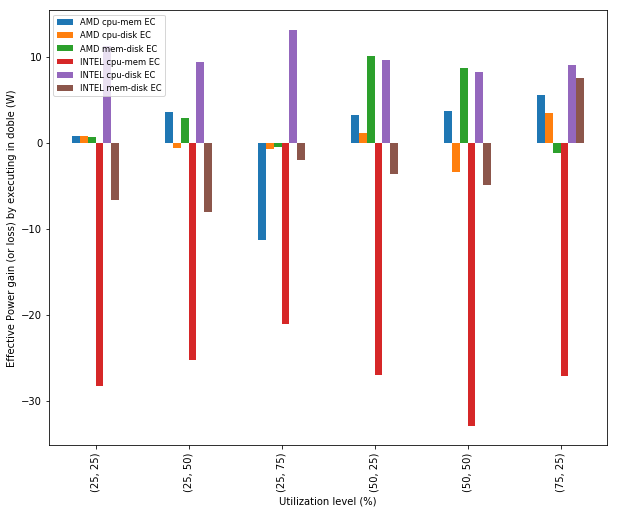

In [17]:
# CPU MEM AMD
df_left = df_exe_energy_double_amd_pw_c1m2

df_right = df_exe_energy_single_amd_c1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_right = df_exe_energy_single_amd_m2_pw    

df_result = pd.merge(df_result, df_right, how='left', left_on=['ULy'],right_on= ['UL'])
df_result = df_result[['ULx','ULy', 'power_average_x', 'power_average_y', 'power_average']]
df_result.columns = ['ULx','ULy', 'AMD cpu + mem PC', 'AMD cpu PC','AMD mem PC']

df_result_AMD_CPUMEM = pd.concat([\
                    df_result,\
                    (df_result['AMD cpu + mem PC'] - AMD_IDLE_PC-\
                    (df_result['AMD cpu PC'] + df_result['AMD mem PC'] - AMD_IDLE_PC - AMD_IDLE_PC))*-1,\
                    ],axis=1)

df_result_AMD_CPUMEM.columns = ['ULx','ULy', 'AMD cpu + mem PC', 'AMD cpu PC','AMD mem PC',\
                     'AMD cpu-mem EC']
df_result_AMD_CPUMEM = df_result_AMD_CPUMEM[['ULx','ULy',  'AMD cpu-mem EC']]

# CPU DISK AMD
df_left = df_exe_energy_double_amd_pw_c1f1

df_right = df_exe_energy_single_amd_c1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_right = df_exe_energy_single_amd_f1_pw    

df_result = pd.merge(df_result, df_right, how='left', left_on=['ULy'],right_on= ['UL'])
df_result = df_result[['ULx','ULy', 'power_average_x', 'power_average_y', 'power_average']]
df_result.columns = ['ULx','ULy', 'AMD cpu + disk PC', 'AMD cpu PC','AMD disk PC']

df_result_AMD_CPUDISK = pd.concat([\
                    df_result,\
                    (df_result['AMD cpu + disk PC'] - AMD_IDLE_PC-\
                    (df_result['AMD cpu PC'] + df_result['AMD disk PC'] - AMD_IDLE_PC - AMD_IDLE_PC))*-1,\
                    ],axis=1)

df_result_AMD_CPUDISK.columns = ['ULx','ULy', 'AMD cpu + disk PC', 'AMD cpu PC','AMD disk PC',\
                     'AMD cpu-disk EC']
df_result_AMD_CPUDISK = df_result_AMD_CPUDISK[['ULx','ULy',  'AMD cpu-disk EC']]


# MEM DISK AMD
df_left = df_exe_energy_double_amd_pw_m2f1

df_right = df_exe_energy_single_amd_m2_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_right = df_exe_energy_single_amd_f1_pw    

df_result = pd.merge(df_result, df_right, how='left', left_on=['ULy'],right_on= ['UL'])
df_result = df_result[['ULx','ULy', 'power_average_x', 'power_average_y', 'power_average']]
df_result.columns = ['ULx','ULy', 'AMD mem + disk PC', 'AMD mem PC','AMD disk PC']

df_result_AMD_MEMDISK = pd.concat([\
                    df_result,\
                    (df_result['AMD mem + disk PC'] - AMD_IDLE_PC-\
                    (df_result['AMD mem PC'] + df_result['AMD disk PC'] - AMD_IDLE_PC - AMD_IDLE_PC))*-1,\
                    ],axis=1)

df_result_AMD_MEMDISK.columns = ['ULx','ULy', 'AMD mem + disk PC', 'AMD mem PC','AMD disk PC',\
                     'AMD mem-disk EC']
df_result_AMD_MEMDISK = df_result_AMD_MEMDISK[['ULx','ULy', 'AMD mem-disk EC']]


# CPU MEM INTEL
df_left = df_exe_energy_double_intel_pw_c1m2

df_right = df_exe_energy_single_intel_c1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_right = df_exe_energy_single_intel_m2_pw    

df_result = pd.merge(df_result, df_right, how='left', left_on=['ULy'],right_on= ['UL'])
df_result = df_result[['ULx','ULy', 'power_average_x', 'power_average_y', 'power_average']]
df_result.columns = ['ULx','ULy', 'INTEL cpu + mem PC', 'INTEL cpu PC','INTEL mem PC']

df_result_INTEL_CPUMEM = pd.concat([\
                    df_result,\
                    (df_result['INTEL cpu + mem PC'] - INTEL_IDLE_PC-\
                    (df_result['INTEL cpu PC'] + df_result['INTEL mem PC'] - INTEL_IDLE_PC - INTEL_IDLE_PC))*-1,\
                    ],axis=1)

df_result_INTEL_CPUMEM.columns = ['ULx','ULy', 'INTEL cpu + mem PC', 'INTEL cpu PC','INTEL mem PC',\
                     'INTEL cpu-mem EC']
df_result_INTEL_CPUMEM = df_result_INTEL_CPUMEM[['ULx','ULy',  'INTEL cpu-mem EC']]

# CPU DISK INTEL
df_left = df_exe_energy_double_intel_pw_c1f1

df_right = df_exe_energy_single_intel_c1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_right = df_exe_energy_single_intel_f1_pw    

df_result = pd.merge(df_result, df_right, how='left', left_on=['ULy'],right_on= ['UL'])
df_result = df_result[['ULx','ULy', 'power_average_x', 'power_average_y', 'power_average']]
df_result.columns = ['ULx','ULy', 'INTEL cpu + disk PC', 'INTEL cpu PC','INTEL disk PC']

df_result_INTEL_CPUDISK = pd.concat([\
                    df_result,\
                    (df_result['INTEL cpu + disk PC'] - INTEL_IDLE_PC-\
                    (df_result['INTEL cpu PC'] + df_result['INTEL disk PC'] - INTEL_IDLE_PC - INTEL_IDLE_PC))*-1,\
                    ],axis=1)

df_result_INTEL_CPUDISK.columns = ['ULx','ULy', 'INTEL cpu + disk PC', 'INTEL cpu PC','INTEL disk PC',\
                     'INTEL cpu-disk EC']
df_result_INTEL_CPUDISK = df_result_INTEL_CPUDISK[['ULx','ULy',  'INTEL cpu-disk EC']]


# MEM DISK INTEL
df_left = df_exe_energy_double_intel_pw_m2f1

df_right = df_exe_energy_single_intel_m2_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_right = df_exe_energy_single_intel_f1_pw    

df_result = pd.merge(df_result, df_right, how='left', left_on=['ULy'],right_on= ['UL'])
df_result = df_result[['ULx','ULy', 'power_average_x', 'power_average_y', 'power_average']]
df_result.columns = ['ULx','ULy', 'INTEL mem + disk PC', 'INTEL mem PC','INTEL disk PC']

df_result_INTEL_MEMDISK = pd.concat([\
                    df_result,\
                    (df_result['INTEL mem + disk PC'] - INTEL_IDLE_PC-\
                    (df_result['INTEL mem PC'] + df_result['INTEL disk PC'] - INTEL_IDLE_PC - INTEL_IDLE_PC))*-1,\
                    ],axis=1)

df_result_INTEL_MEMDISK.columns = ['ULx','ULy', 'INTEL mem + disk PC', 'INTEL mem PC','INTEL disk PC',\
                     'INTEL mem-disk EC']
df_result_INTEL_MEMDISK = df_result_INTEL_MEMDISK[['ULx','ULy', 'INTEL mem-disk EC']]





#print all together
df_result = pd.concat([\
                    df_result_AMD_CPUMEM,\
                    df_result_AMD_CPUDISK['AMD cpu-disk EC'],\
                    df_result_AMD_MEMDISK['AMD mem-disk EC'],\
                    df_result_INTEL_CPUMEM['INTEL cpu-mem EC'],\
                    df_result_INTEL_CPUDISK['INTEL cpu-disk EC'],\
                    df_result_INTEL_MEMDISK['INTEL mem-disk EC'],\
                   
                    ],axis=1) 


display(df_result,'Energy double VS single energy gain')
aux= df_result.plot(x= ['ULx','ULy'],y=['AMD cpu-mem EC',\
                                   'AMD cpu-disk EC',\
                                  'AMD mem-disk EC',\
                                   'INTEL cpu-mem EC',\
                                   'INTEL cpu-disk EC',\
                                  'INTEL mem-disk EC',\
                                  
                                  ],kind='bar',figsize=(10, 8))

aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Effective Power gain (or loss) by executing in doble (W)")


### POWER CONSUMPTION. SINGLE VS TRIPLE

The following code compares the effective power consumption of executes in sigle or triple modality.

,ULx,ULy,ULz,AMD cpu + mem + disk PC,AMD cpu PC,AMD mem PC,AMD disk PC,AMD cpu + mem + disk EC,INTEL cpu + mem + disk PC,INTEL cpu PC,INTEL mem PC,INTEL disk PC,INTEL cpu + mem + disk EC
0,25,25,25,4.481,204.952,238.664,189.285,261.620,4.074,136.552,156.342,68.018,242.838
1,25,25,50,4.747,204.952,238.664,189.300,261.369,3.489,136.552,156.342,68.864,244.269
2,25,50,25,3.185,204.952,272.349,189.285,296.601,5.520,136.552,191.757,68.018,276.807
3,50,25,25,1.692,225.050,238.664,189.285,284.507,4.997,152.800,156.342,68.018,258.163


'Energy double VS single energy gain'

/home/jon/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



Text(0,0.5,'Effective Power gain (or loss) by executing in triple (W)')

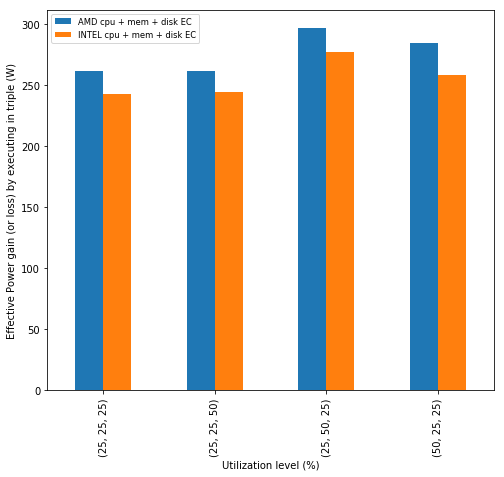

In [18]:
#AMD
df_left = df_exe_energy_triple_amd_pw_c1m2f1

df_right = df_exe_energy_single_amd_c1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_left = df_result
df_right = df_exe_energy_single_amd_m2_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULy'],right_on= ['UL'])

df_left = df_result
df_right = df_exe_energy_single_amd_f1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULz'],right_on= ['UL'])

df_result.columns = ['ULx','ULy','ULz', 'AMD cpu + mem + disk PC','foo1', 'AMD cpu PC','foo2',\
                     'AMD mem PC','foo3','AMD disk PC']

df_result = df_result[['ULx','ULy','ULz', 'AMD cpu + mem + disk PC', 'AMD cpu PC',\
                     'AMD mem PC','AMD disk PC']]

df_result_AMD_CPUMEMDISK = pd.concat([\
                    df_result,\
                    (df_result['AMD cpu + mem + disk PC'] - AMD_IDLE_PC-\
                    (df_result['AMD cpu PC'] + df_result['AMD mem PC'] + df_result['AMD disk PC'] \
                     - AMD_IDLE_PC * 3))*-1,\
                    ],axis=1)

df_result_AMD_CPUMEMDISK.columns = ['ULx','ULy','ULz', 'AMD cpu + mem + disk PC', 'AMD cpu PC',\
                     'AMD mem PC','AMD disk PC','AMD cpu + mem + disk EC']

#INTEL
df_left = df_exe_energy_triple_intel_pw_c1m2f1

df_right = df_exe_energy_single_intel_c1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_left = df_result
df_right = df_exe_energy_single_intel_m2_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULy'],right_on= ['UL'])

df_left = df_result
df_right = df_exe_energy_single_intel_f1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULz'],right_on= ['UL'])

df_result.columns = ['ULx','ULy','ULz', 'INTEL cpu + mem + disk PC','foo1', 'INTEL cpu PC','foo2',\
                     'INTEL mem PC','foo3','INTEL disk PC']

df_result = df_result[['ULx','ULy','ULz', 'INTEL cpu + mem + disk PC', 'INTEL cpu PC',\
                     'INTEL mem PC','INTEL disk PC']]

df_result_INTEL_CPUMEMDISK = pd.concat([\
                    df_result,\
                    (df_result['INTEL cpu + mem + disk PC'] - INTEL_IDLE_PC-\
                    (df_result['INTEL cpu PC'] + df_result['INTEL mem PC'] + df_result['INTEL disk PC'] \
                     - INTEL_IDLE_PC * 3))*-1,\
                    ],axis=1)

df_result_INTEL_CPUMEMDISK.columns = ['ULx','ULy','ULz', 'INTEL cpu + mem + disk PC', 'INTEL cpu PC',\
                     'INTEL mem PC','INTEL disk PC','INTEL cpu + mem + disk EC']

#print all together
df_result = pd.concat([\
                    df_result_AMD_CPUMEMDISK,\
                    df_result_INTEL_CPUMEMDISK\
                       [['INTEL cpu + mem + disk PC', 'INTEL cpu PC',\
                     'INTEL mem PC','INTEL disk PC','INTEL cpu + mem + disk EC']]\
                    ],axis=1) 

display(df_result,'Energy double VS single energy gain')

aux=df_result.plot(x= ['ULx','ULy','ULz'],y=['AMD cpu + mem + disk EC',\
                                'INTEL cpu + mem + disk EC',
                                  ],kind='bar',figsize=(8, 7))

aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Effective Power gain (or loss) by executing in triple (W)")



## 5 Data modeling

In this section the previous data is utilized to find dependencies between the variables of the problem:

- utilization level 
- power consumption
- resources bound
- host architecture


### ENERGY  MODEL 1 - ONLY CPU-INTENSIVE WORKLOAD

The first and simplest model considers only the dependency between utilization level and power consumption. In this model all the workload is considered CPU-bound. The following ecuation shows the relation, where $\alpha$ is the utilization level and $e$ is the power consumption predicted. 

\begin{equation} 
f(\alpha) \to e,\;
\alpha \in [0,100] \wedge e \in \rm I\!R
\end{equation}

The experimental data considered to this model is the CPU-bound benchmark execution on AMD an Intel host.

In [19]:
df_exe_energy_single_amd_c1_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='c1']\
         .groupby(['UL']).mean().reset_index()

df_exe_energy_single_intel_c1_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='c1']\
         .groupby(['UL']).mean().reset_index()
       
display(pd.concat([df_exe_energy_single_amd_c1_pw,df_exe_energy_single_intel_c1_pw],axis=1))    


,UL,power_average,UL,power_average
0,12.5,194.379,12.5,121.587
1,25.0,204.952,25.0,136.552
2,37.5,215.094,37.5,142.532
3,50.0,225.050,50.0,152.800
4,62.5,235.494,62.5,163.191
5,75.0,246.022,75.0,175.770
6,87.5,254.690,87.5,185.827
7,100.0,264.068,100.0,194.640


#### Linear regresion

Model 1 can be resolved by linear regretion. The following code resolves the problem and shows the parameter founded. The model can be adjunted....


Text(0.5,1,'Intel linear model')

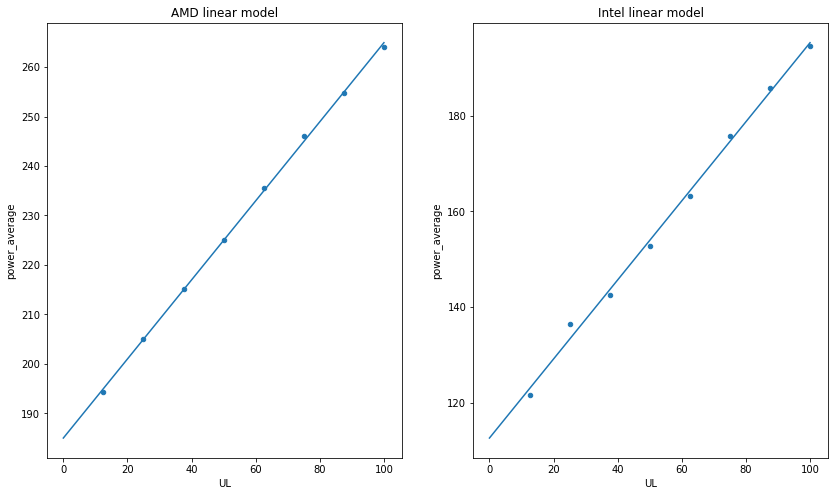

In [23]:
# create linear model 
linear_model_amd = smf.ols(formula='power_average ~ UL', data=df_exe_energy_single_amd_c1_pw).fit()
linear_model_intel = smf.ols(formula='power_average ~ UL', data=df_exe_energy_single_intel_c1_pw).fit()

# Showing coef
#print(linear_model_amd.params)
#print(linear_model_intel.params)


X_theoretical = pd.DataFrame({'UL': [0, 100]})

predict_amd = linear_model_amd.predict(X_theoretical)
predict_intel = linear_model_intel.predict(X_theoretical)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(14, 8))
ax1.plot(X_theoretical, predict_amd)
df_exe_energy_single_amd_c1_pw.plot(kind='scatter', x='UL', y='power_average', ax=ax1)
ax1.set_title('AMD linear model')
ax2.plot(X_theoretical, predict_intel)
df_exe_energy_single_intel_c1_pw.plot(kind='scatter', x='UL', y='power_average', ax=ax2)
ax2.set_title('Intel linear model')



Python provides test over the models

In [48]:
print (linear_model_amd.summary())
print (linear_model_intel.summary())

/home/jon/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=8



                            OLS Regression Results                            
Dep. Variable:          power_average   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     9523.
Date:                Tue, 22 May 2018   Prob (F-statistic):           7.80e-11
Time:                        21:45:48   Log-Likelihood:                -6.9237
No. Observations:                   8   AIC:                             17.85
Df Residuals:                       6   BIC:                             18.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    184.9822      0.517    357.593      0.0

### ENERGY MODEL 2

The second model considers the dependency between type of computational resuorce, utilization level and power consumption. However, the intelationship in the combined execution is not considered. The following ecuation shows the relation, where $\alpha$ is the utilization level of CPU, $\beta$ is the utilization level of memory, $\gamma$ is the utilization level of disk and $e$ is the power consumption predicted. 

\begin{equation} 
f(\alpha,\beta,\gamma) \to e,\;
\alpha \in [0,100] \wedge e \in \rm I\!R
\end{equation}

The experimental data considered to this model is the single CPU-bound, Memory-bound and Disk-bound benchmark executions,  on AMD an Intel host.



In [49]:
df_exe_energy_single_amd_c1_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='c1']\
         .groupby(['UL']).mean().reset_index()

df_exe_energy_single_intel_c1_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='c1']\
         .groupby(['UL']).mean().reset_index()
       
df_exe_energy_single_amd_m2_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='m2']\
         .groupby(['UL']).mean().reset_index()

df_exe_energy_single_intel_m2_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='m2']\
         .groupby(['UL']).mean().reset_index()

df_exe_energy_single_amd_f1_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='f1']\
         .groupby(['UL']).mean().reset_index()

df_exe_energy_single_intel_f1_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='f1']\
         .groupby(['UL']).mean().reset_index()
      
df_exe_energy_single_amd_pw =   pd.concat(\
    [df_exe_energy_single_amd_c1_pw,\
     df_exe_energy_single_amd_m2_pw,\
     df_exe_energy_single_amd_f1_pw]\
    ,axis=1)  
    
df_exe_energy_single_amd_pw.columns = ['ul_cpu','power_cpu','ul_mem', 'power_mem','ul_disk','power_disk']

df_exe_energy_single_intel_pw =   pd.concat(\
    [df_exe_energy_single_intel_c1_pw,\
     df_exe_energy_single_intel_m2_pw,\
     df_exe_energy_single_intel_f1_pw]\
    ,axis=1)  
    
df_exe_energy_single_intel_pw.columns = ['ul_cpu','power_cpu','ul_mem', 'power_mem','ul_disk','power_disk']



# IDLE substraction
df_exe_energy_single_amd_pw.power_cpu = df_exe_energy_single_amd_pw.power_cpu - AMD_IDLE_PC
df_exe_energy_single_amd_pw.power_mem = df_exe_energy_single_amd_pw.power_mem - AMD_IDLE_PC
df_exe_energy_single_amd_pw.power_disk = df_exe_energy_single_amd_pw.power_disk - AMD_IDLE_PC
    
df_exe_energy_single_amd_pw['power'] = df_exe_energy_single_amd_pw.power_cpu+\
df_exe_energy_single_amd_pw.power_mem+\
df_exe_energy_single_amd_pw.power_disk

df_exe_energy_single_intel_pw.power_cpu = df_exe_energy_single_intel_pw.power_cpu - INTEL_IDLE_PC
df_exe_energy_single_intel_pw.power_mem = df_exe_energy_single_intel_pw.power_mem - INTEL_IDLE_PC
df_exe_energy_single_intel_pw.power_disk = df_exe_energy_single_intel_pw.power_disk - INTEL_IDLE_PC
    
df_exe_energy_single_intel_pw['power'] = df_exe_energy_single_intel_pw.power_cpu+\
df_exe_energy_single_intel_pw.power_mem+\
df_exe_energy_single_intel_pw.power_disk


#display(df_exe_energy_single_amd_pw) 
   

### Linear model
We consider three linear models independly

In [50]:
# create linear model 
linear_model_amd_cpu = smf.ols(formula='power_cpu ~ ul_cpu', \
                           data=df_exe_energy_single_amd_pw).fit()

linear_model_amd_mem = smf.ols(formula='power_mem ~ ul_mem', \
                           data=df_exe_energy_single_amd_pw).fit()

linear_model_amd_disk = smf.ols(formula='power_disk ~ ul_disk', \
                           data=df_exe_energy_single_amd_pw).fit()

# create linear model 
linear_model_intel_cpu = smf.ols(formula='power_cpu ~ ul_cpu', \
                           data=df_exe_energy_single_intel_pw).fit()

linear_model_intel_mem = smf.ols(formula='power_mem ~ ul_mem', \
                           data=df_exe_energy_single_intel_pw).fit()

linear_model_intel_disk = smf.ols(formula='power_disk ~ ul_disk', \
                           data=df_exe_energy_single_intel_pw).fit()


#print(linear_model_intel_cpu.params)
#print(linear_model_intel_mem.params)
#print(linear_model_amd_cpu.params)
#print(linear_model_amd_mem.params)
#print(linear_model_amd_mem.summary())
#print(linear_model_intel_mem.params)
#print(linear_model_amd_cpu.params)
#print(linear_model_amd_mem.params)
# Showing coef
#print(linear_model_amd_cpu.params)
#print(linear_model_amd_mem.params)
#print(linear_model_amd_disk.params)


Text(0,0.5,'Power Consumption (W)')

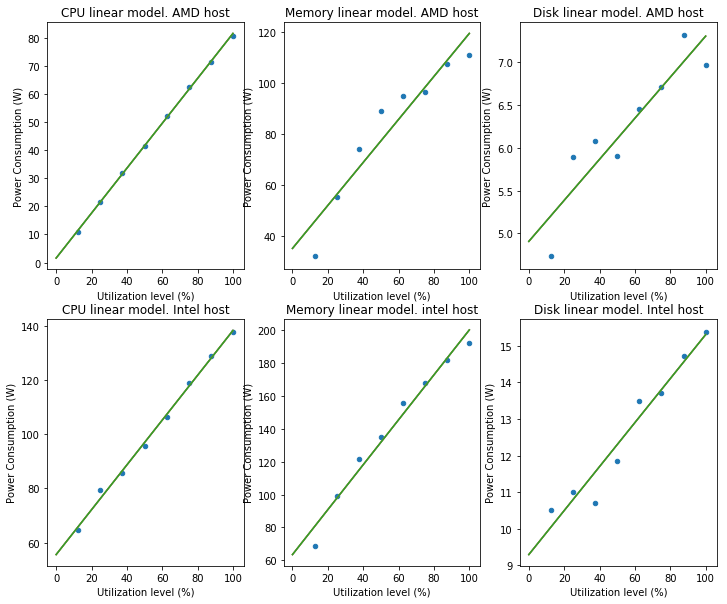

In [51]:
X_theoretical = pd.DataFrame({'ul_cpu': [0, 100],'ul_mem': [0, 100],'ul_disk': [0, 100]})


predict_amd_cpu = linear_model_amd_cpu.predict(X_theoretical)
predict_amd_mem = linear_model_amd_mem.predict(X_theoretical)
predict_amd_disk = linear_model_amd_disk.predict(X_theoretical)

predict_intel_cpu = linear_model_intel_cpu.predict(X_theoretical)
predict_intel_mem = linear_model_intel_mem.predict(X_theoretical)
predict_intel_disk = linear_model_intel_disk.predict(X_theoretical)


f, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, sharey=False, figsize=(12, 10))

ax1.plot(X_theoretical, predict_amd_cpu)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu', ax=ax1)
ax1.set_title('CPU linear model. AMD host')
ax2.plot(X_theoretical, predict_amd_mem)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax2)
ax2.set_title('Memory linear model. AMD host')

ax3.plot(X_theoretical, predict_amd_disk)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_disk', y='power_disk', ax=ax3)
ax3.set_title('Disk linear model. AMD host')

ax1.set_xlabel("Utilization level (%)")
ax1.set_ylabel("Power Consumption (W)")
ax2.set_xlabel("Utilization level (%)")
ax2.set_ylabel("Power Consumption (W)")
ax3.set_xlabel("Utilization level (%)")
ax3.set_ylabel("Power Consumption (W)")



ax4.plot(X_theoretical, predict_intel_cpu)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu', ax=ax4)
ax4.set_title('CPU linear model. Intel host')
ax5.plot(X_theoretical, predict_intel_mem)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax5)
ax5.set_title('Memory linear model. intel host')
ax6.plot(X_theoretical, predict_intel_disk)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_disk', y='power_disk', ax=ax6)
ax6.set_title('Disk linear model. Intel host')

ax4.set_xlabel("Utilization level (%)")
ax4.set_ylabel("Power Consumption (W)")
ax5.set_xlabel("Utilization level (%)")
ax5.set_ylabel("Power Consumption (W)")
ax6.set_xlabel("Utilization level (%)")
ax6.set_ylabel("Power Consumption (W)")



Next the R-suared metric of the models is showed.

In [52]:
print("CPU model. AMD. R-squared: ",linear_model_amd_cpu.rsquared)
print("Memory model. AMD. R-squared: ",linear_model_amd_mem.rsquared)
print("Disk model. AMD. R-squared: ",linear_model_amd_disk.rsquared)
print("CPU model. Intel. R-squared: ",linear_model_amd_cpu.rsquared)
print("Memory model R-squared: ",linear_model_amd_mem.rsquared)
print("Disk model R-squared: ",linear_model_amd_disk.rsquared)

CPU model. AMD. R-squared:  0.99937037534
Memory model. AMD. R-squared:  0.903133318017
Disk model. AMD. R-squared:  0.844645389182
CPU model. Intel. R-squared:  0.99937037534
Memory model R-squared:  0.903133318017
Disk model R-squared:  0.844645389182


### Improving the model. CPU

It is posible adjust the cpu model for impoving the R-squared metric. Quadratic and piecewise function is presented below.

Intercept              3.772e-02
ul_cpu                 8.739e-01
np.power(ul_cpu, 2)   -6.590e-04
dtype: float64
0.999794433623
Intercept              5.572e+01
ul_cpu                 8.218e-01
np.power(ul_cpu, 2)    4.228e-05
dtype: float64
0.995837242114


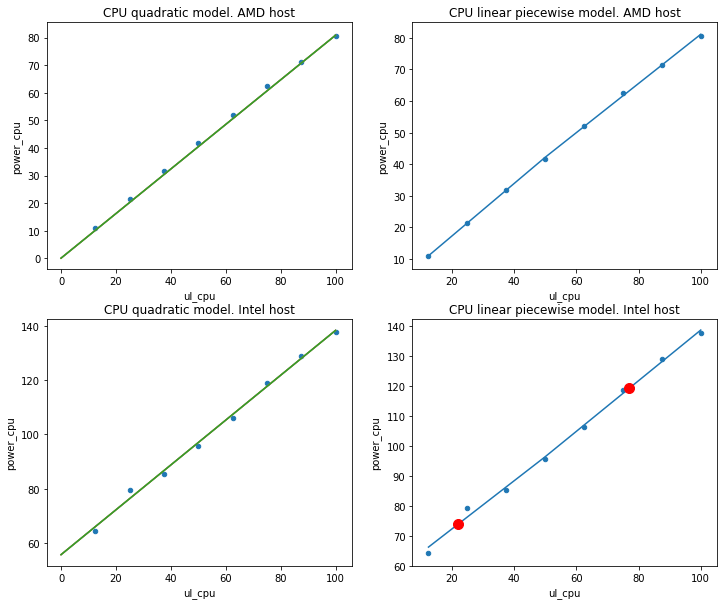

In [53]:
linear_model_amd_cpu_2 = smf.ols(formula='power_cpu ~ ul_cpu + np.power(ul_cpu,2)', \
                           data=df_exe_energy_single_amd_pw).fit()

predict_amd_cpu_2 = linear_model_amd_cpu_2.predict(X_theoretical)

linear_model_intel_cpu_2 = smf.ols(formula='power_cpu ~ ul_cpu + np.power(ul_cpu,2)', \
                           data=df_exe_energy_single_intel_pw).fit()

predict_intel_cpu_2 = linear_model_intel_cpu_2.predict(X_theoretical)




f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey=False, figsize=(12, 10))
ax1.plot(X_theoretical, predict_amd_cpu_2)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu', ax=ax1)
ax1.set_title('CPU quadratic model. AMD host')

ax3.plot(X_theoretical, predict_intel_cpu_2)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu', ax=ax3)
ax3.set_title('CPU quadratic model. Intel host')


print(linear_model_amd_cpu_2.params)
print(linear_model_amd_cpu_2.rsquared)
print(linear_model_intel_cpu_2.params)
print(linear_model_intel_cpu_2.rsquared)


#AMD

# piecewise linear data prepare
ul_cpu2 = np.where(df_exe_energy_single_amd_pw['ul_cpu'] > 50, df_exe_energy_single_amd_pw['ul_cpu'] - 50, 0)

df_exe_energy_single_amd_pw['ul_cpu2'] = ul_cpu2

#print(df_exe_energy_single_amd_pw)

# piecewise linear regression
linear_model_amd_cpu_3 = smf.ols(formula = 'power_cpu ~ ul_cpu + ul_cpu2', data = df_exe_energy_single_amd_pw).fit()
predict_amd_cpu_3 = linear_model_amd_cpu_3.predict()

ax2.plot(df_exe_energy_single_amd_pw.ul_cpu,predict_amd_cpu_3)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu',ax=ax2)
ax2.set_title('CPU linear piecewise model. AMD host')




#INTEL

# piecewise linear data prepare
ul_cpu2 = np.where(df_exe_energy_single_amd_pw['ul_cpu'] > 50, df_exe_energy_single_amd_pw['ul_cpu'] - 50, 0)

df_exe_energy_single_intel_pw['ul_cpu2'] = ul_cpu2

#print(df_exe_energy_single_amd_pw)

# piecewise linear regression
linear_model_intel_cpu_3 = smf.ols(formula = 'power_cpu ~ ul_cpu + ul_cpu2', data = df_exe_energy_single_intel_pw).fit()
predict_intel_cpu_3 = linear_model_intel_cpu_3.predict()

ax4.plot(df_exe_energy_single_intel_pw.ul_cpu,predict_intel_cpu_3)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu',ax=ax4)
ax4.set_title('CPU linear piecewise model. Intel host')

#Sowing two examples of piecewise model usage
x_test1 = 22
x_test2 = 77
# auxiliar function
H = lambda h: h-50 if h>50 else 0

y_test1,y_test2=linear_model_intel_cpu_3.predict(pd.DataFrame({'ul_cpu': [x_test1,x_test2],\
                                                     'ul_cpu2': [H(x_test1),H(x_test2)]}))
plt.plot([x_test1], [y_test1], marker='o', markersize=10, color="red")
plt.plot([x_test2], [y_test2], marker='o', markersize=10, color="red")

#print("y_test2="+str(y_test2))
#ax1.set_xlabel("Utilization level (%)")
#ax1.set_ylabel("Power Consumption (W)")
#ax2.set_xlabel("Utilization level (%)")
#ax2.set_ylabel("Power Consumption (W)")
#print(linear_model_amd_cpu_3.params)
#print(linear_model_intel_cpu_3.rsquared)
#print(linear_model_intel_cpu_3.params)
#print(linear_model_intel_cpu_3.rsquared)







### Improving the model. Memory


It is posible adjust the memory model for impoving the R-squared metric. Quadratic and piecewise function is presented below.

Intercept              11.269
ul_mem                  1.987
np.power(ul_mem, 2)    -0.010
dtype: float64
0.984298587323
Intercept              44.277
ul_mem                  2.287
np.power(ul_mem, 2)    -0.008
dtype: float64
0.996663543564
y_test2=101.19967019536779


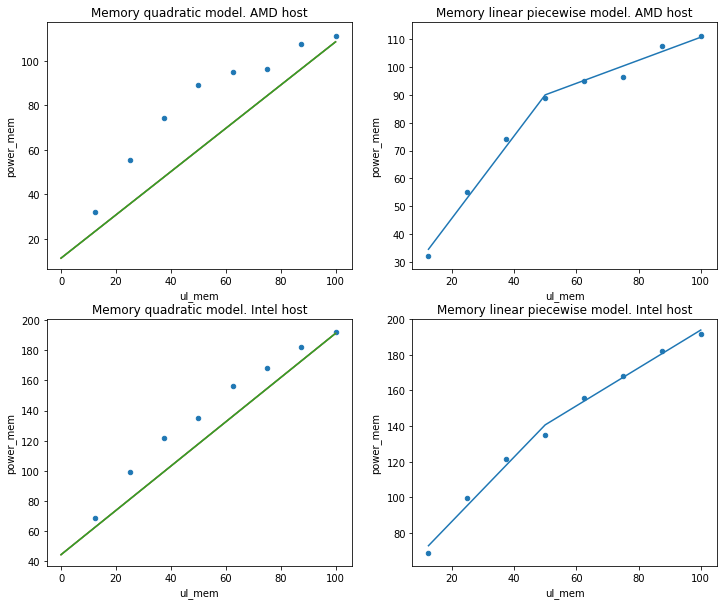

In [54]:
linear_model_amd_mem_2 = smf.ols(formula='power_mem ~ ul_mem + np.power(ul_mem,2)', \
                           data=df_exe_energy_single_amd_pw).fit()

predict_amd_mem_2 = linear_model_amd_mem_2.predict(X_theoretical)

linear_model_intel_mem_2 = smf.ols(formula='power_mem ~ ul_mem + np.power(ul_mem,2)', \
                           data=df_exe_energy_single_intel_pw).fit()

predict_intel_mem_2 = linear_model_intel_mem_2.predict(X_theoretical)

#X_theoretical = pd.DataFrame({'ul_cpu': [0, 100],'ul_mem': [0, 100],'ul_disk': [0, 100]})



f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, sharey=False, figsize=(12, 10))
ax1.plot(X_theoretical, predict_amd_mem_2)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax1)
ax1.set_title('Memory quadratic model. AMD host')

ax3.plot(X_theoretical, predict_intel_mem_2)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax3)
ax3.set_title('Memory quadratic model. Intel host')



print(linear_model_amd_mem_2.params)
print(linear_model_amd_mem_2.rsquared)
print(linear_model_intel_mem_2.params)
print(linear_model_intel_mem_2.rsquared)


#AMD

# piecewise linear data prepare
ul_mem2 = np.where(df_exe_energy_single_amd_pw['ul_mem'] > 50, df_exe_energy_single_amd_pw['ul_mem'] - 50, 0)

df_exe_energy_single_amd_pw['ul_mem2'] = ul_mem2

#print(df_exe_energy_single_amd_pw)

# piecewise linear regression
linear_model_amd_mem_3 = smf.ols(formula = 'power_mem ~ ul_mem + ul_mem2', data = df_exe_energy_single_amd_pw).fit()
predict_amd_mem_3 = linear_model_amd_mem_3.predict()

ax2.plot(df_exe_energy_single_amd_pw.ul_mem,predict_amd_mem_3)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax2)
ax2.set_title('Memory linear piecewise model. AMD host')



#Sowing two examples of piecewise model usage
x_test1 = 22
x_test2 = 77
# auxiliar function
H = lambda h: h-50 if h>50 else 0

y_test1,y_test2=linear_model_amd_mem_3.predict(pd.DataFrame({'ul_mem': [x_test1,x_test2],\
                                                     'ul_mem2': [H(x_test1),H(x_test2)]}))
#plt.plot([x_test1], [y_test1], marker='o', markersize=10, color="red")
#plt.plot([x_test2], [y_test2], marker='o', markersize=10, color="red")

print("y_test2="+str(y_test2))

#INTEL

# piecewise linear data prepare
ul_mem2 = np.where(df_exe_energy_single_amd_pw['ul_mem'] > 50, df_exe_energy_single_amd_pw['ul_mem'] - 50, 0)

df_exe_energy_single_intel_pw['ul_mem2'] = ul_mem2

#print(df_exe_energy_single_amd_pw)

# piecewise linear regression
linear_model_intel_mem_3 = smf.ols(formula = 'power_mem ~ ul_mem + ul_mem2', data = df_exe_energy_single_intel_pw).fit()
predict_intel_mem_3 = linear_model_intel_mem_3.predict()

ax4.plot(df_exe_energy_single_intel_pw.ul_mem,predict_intel_mem_3)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax4)
ax4.set_title('Memory linear piecewise model. Intel host')


#Sowing two examples of piecewise model usage
x_test1 = 22
x_test2 = 77
# auxiliar function
H = lambda h: h-50 if h>50 else 0

y_test1,y_test2=linear_model_intel_mem_3.predict(pd.DataFrame({'ul_mem': [x_test1,x_test2],\
                                                     'ul_mem2': [H(x_test1),H(x_test2)]}))
#plt.plot([x_test1], [y_test1], marker='o', markersize=10, color="red")
#plt.plot([x_test2], [y_test2], marker='o', markersize=10, color="red")

#print("y_test2="+str(y_test2))
#Sowing two examples of piecewise model usage
#x_test1 = 22
#x_test2 = 77
# auxiliar function
#H = lambda h: h-50 if h>50 else 0

#y_test1,y_test2=linear_model_amd_mem_3.predict(pd.DataFrame({'ul_mem': [x_test1,x_test2],\
#                                                     'ul_mem2': [H(x_test1),H(x_test2)]}))
#plt.plot([x_test1], [y_test1], marker='o', markersize=10, color="red")
#plt.plot([x_test2], [y_test2], marker='o', markersize=10, color="red")

#ax1.set_xlabel("Utilization level (%)")
#ax1.set_ylabel("Power Consumption (W)")
#ax2.set_xlabel("Utilization level (%)")
#ax2.set_ylabel("Power Consumption (W)")

#print(linear_model_intel_mem_3.params)
#print(linear_model_intel_mem_3.rsquared)
#print(linear_model_intel_mem_3.params)
#print(linear_model_intel_mem_3.rsquared)
#print(linear_model_amd_mem_3.summary())







And new R-squared values are

In [55]:
print("AMD. Linear model R-squared: ",linear_model_amd_cpu.rsquared)
print("INtel. Linear model R-squared: ",linear_model_intel_cpu.rsquared)


print("AMD. Linear model R-squared: ",linear_model_amd_mem.rsquared)
print("AMD. Quadratic model R-squared: ",linear_model_amd_mem_2.rsquared)
print("AMD.Piecewise model R-squared: ",linear_model_amd_mem_3.rsquared)

print("Intel. Linear model R-squared: ",linear_model_intel_mem.rsquared)
print("Intel. Quadratic model R-squared: ",linear_model_intel_mem_2.rsquared)
print("Intel. Piecewise model R-squared: ",linear_model_intel_mem_3.rsquared)

print("Intel. Quadratic model R-squared: ",linear_model_amd_mem_3.params)
print("Intel. Piecewise model R-squared: ",linear_model_intel_mem_3.params)


AMD. Linear model R-squared:  0.99937037534
INtel. Linear model R-squared:  0.995835613444
AMD. Linear model R-squared:  0.903133318017
AMD. Quadratic model R-squared:  0.984298587323
AMD.Piecewise model R-squared:  0.992516889752
Intel. Linear model R-squared:  0.974899155997
Intel. Quadratic model R-squared:  0.996663543564
Intel. Piecewise model R-squared:  0.992937265131
Intel. Quadratic model R-squared:  Intercept    16.012
ul_mem        1.480
ul_mem2      -1.065
dtype: float64
Intel. Piecewise model R-squared:  Intercept    50.131
ul_mem        1.811
ul_mem2      -0.745
dtype: float64


### PERFORMANCE MODEL 1

This model is lineal

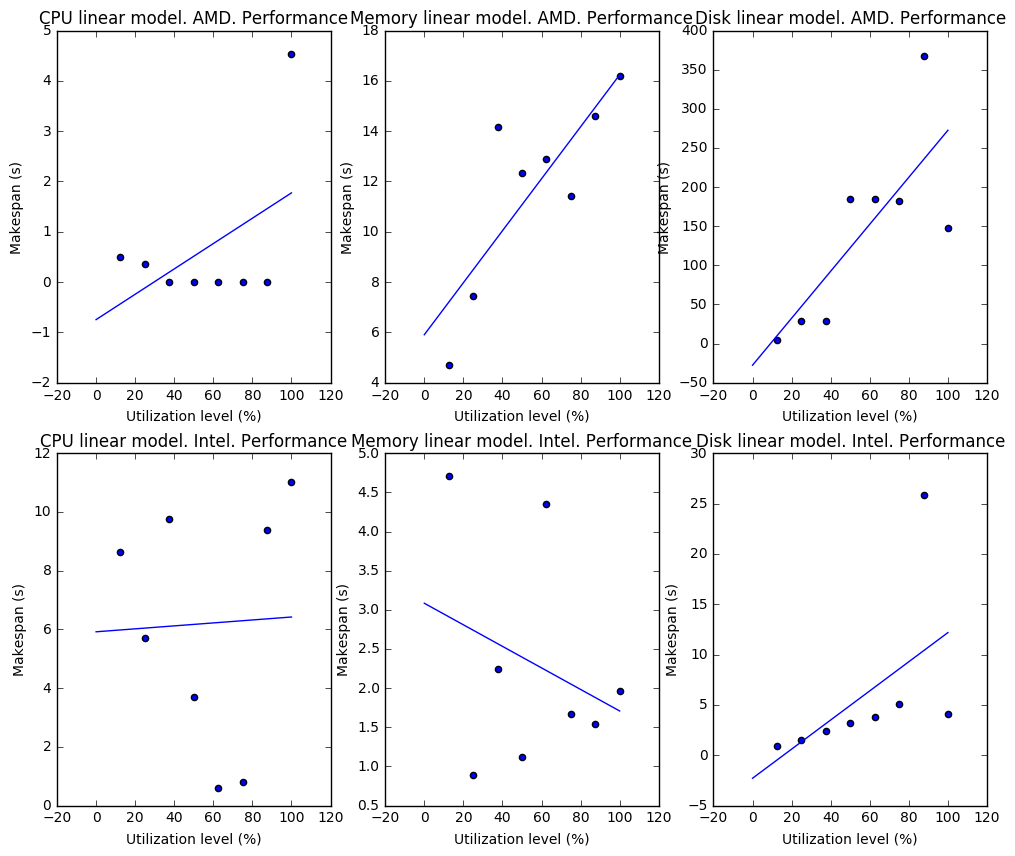

In [38]:
X_theoretical = pd.DataFrame({'UL': [0, 100]})

df_exe_performance_single= pd.concat([df_exe_performance_single_amd_pw_c1unt,\
                    df_exe_performance_single_amd_pw_m2unt['seconds'],\
                    df_exe_performance_single_amd_pw_f1unt['seconds'],\
                   df_exe_performance_single_intel_pw_c1unt['seconds'],\
                    df_exe_performance_single_intel_pw_m2unt['seconds'],\
                    df_exe_performance_single_intel_pw_f1unt['seconds']],\
                  axis=1) 

df_exe_performance_single.columns = ['UL', 'makespan_amd_cpu', 'makespan_amd_mem', 'makespan_amd_disk',\
                                         'makespan_intel_cpu', 'makespan_intel_mem', 'makespan_intel_disk']
#AMD

linear_model_performance_amd_cpu = smf.ols(formula='makespan_amd_cpu ~ UL', \
                           data=df_exe_performance_single).fit()
predict_performance_amd_cpu= linear_model_performance_amd_cpu.predict(X_theoretical)

linear_model_performance_amd_mem = smf.ols(formula='makespan_amd_mem ~ UL', \
                           data=df_exe_performance_single).fit()
predict_performance_amd_mem= linear_model_performance_amd_mem.predict(X_theoretical)

linear_model_performance_amd_disk = smf.ols(formula='makespan_amd_disk ~ UL', \
                           data=df_exe_performance_single).fit()
predict_performance_amd_disk= linear_model_performance_amd_disk.predict(X_theoretical)

#INTEL

linear_model_performance_intel_cpu = smf.ols(formula='makespan_intel_cpu ~ UL', \
                           data=df_exe_performance_single).fit()
predict_performance_intel_cpu= linear_model_performance_intel_cpu.predict(X_theoretical)

linear_model_performance_intel_mem = smf.ols(formula='makespan_intel_mem ~ UL', \
                           data=df_exe_performance_single).fit()
predict_performance_intel_mem= linear_model_performance_intel_mem.predict(X_theoretical)

linear_model_performance_intel_disk = smf.ols(formula='makespan_intel_disk ~ UL', \
                           data=df_exe_performance_single).fit()
predict_performance_intel_disk= linear_model_performance_intel_disk.predict(X_theoretical)


f, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, sharey=False, figsize=(12, 10))

ax1.plot(X_theoretical, predict_performance_amd_cpu)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_cpu', ax=ax1)
ax1.set_title('CPU linear model. AMD. Performance')

ax2.plot(X_theoretical, predict_performance_amd_mem)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_mem', ax=ax2)
ax2.set_title('Memory linear model. AMD. Performance')

ax3.plot(X_theoretical, predict_performance_amd_disk)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_disk', ax=ax3)
ax3.set_title('Disk linear model. AMD. Performance')

ax4.plot(X_theoretical, predict_performance_intel_cpu)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_cpu', ax=ax4)
ax4.set_title('CPU linear model. Intel. Performance')

ax5.plot(X_theoretical, predict_performance_intel_mem)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_mem', ax=ax5)
ax5.set_title('Memory linear model. Intel. Performance')

ax6.plot(X_theoretical, predict_performance_intel_disk)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_disk', ax=ax6)
ax6.set_title('Disk linear model. Intel. Performance')



ax1.set_xlabel("Utilization level (%)")
ax1.set_ylabel("Makespan (s)")
ax2.set_xlabel("Utilization level (%)")
ax2.set_ylabel("Makespan (s)")
ax3.set_xlabel("Utilization level (%)")
ax3.set_ylabel("Makespan (s)")
ax4.set_xlabel("Utilization level (%)")
ax4.set_ylabel("Makespan (s)")
ax5.set_xlabel("Utilization level (%)")
ax5.set_ylabel("Makespan (s)")
ax6.set_xlabel("Utilization level (%)")
ax6.set_ylabel("Makespan (s)")



## 6 Conclusion and Future Work

This notebook presented detailed python scripts for proccesing output files of power characterization experiments. It allows to expose the scientific method in a clear manner and minimize errors in calculations. Also, the processing is completely reproducible from raw data. The work shows different analysis of the data, comparing combined and single scenarios, taking advantage of pandas dataframe potential. Finally, different power consumption models are presented and implemented using linear regression. The python models are implemented easily and without errors. Several error tests over the models are provided by the framework. In the future more complex models (that consider the dependency of the combined execution) are going to be implemented. 


## 7 References


- [The publication related to this work](https://link.springer.com/chapter/10.1007/978-3-319-73353-1_2).
- [Piecewise model explanation](http://songhuiming.github.io/pages/2015/09/22/piecewise-linear-function-and-the-explanation/). Accessed: Jan 29, 2018
- [R-squared metric](https://en.wikipedia.org/wiki/Coefficient_of_determination). Accessed: Jan 20, 2018


## Extra

#### STATISICTICS TEST

Example of statistics test applied over AMD data, simple executions

In [39]:
def printStatisticTests(experiments):
    shapiro_results =  experiments.apply(lambda x:scipy.stats.shapiro(x),axis = 0) 
    ks_results =  experiments.apply(lambda x:scipy.stats.kstest(x,cdf='norm'),axis = 0) 
    anderson_results =  experiments.apply(lambda x:scipy.stats.anderson(x),axis = 0) 
    dagostino_results =  experiments.apply(lambda x:scipy.stats.mstats.normaltest(x),axis = 0) 
    tests=pd.concat([shapiro_results,
                    ks_results,
                     anderson_results,
                     dagostino_results
                    ]
                    
                    ,axis=1)
    tests.columns = ['Shapiro-Wilk',
                       'Kolmogorov-Smirnov',
                       'Anderson-Darling',
                       'D’Agostino and Pearson',
                      ]
    display(tests)

#AMD CPU
experiments = pd.DataFrame()
experiments = pd.concat(
    [
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l12y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l25']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l37y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l50']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l62y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l75']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l87y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l100']['power_average'].reset_index()
    ],axis=1)  
experiments = experiments.drop(['index'], axis=1)
#display(experiments)
experiments.columns = ['c1l12y5',
                       'c1l25',
                       'c1l37y5',
                       'c1l50',
                       'c1l62y5',
                       'c1l75',
                       'c1l87y5',
                       'c1l100',
                      ]

printStatisticTests(experiments)

#AMD MEM
experiments = pd.DataFrame()
experiments = pd.concat(
    [
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l12y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l25']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l37y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l50']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l62y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l75']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l87y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l100']['power_average'].reset_index()
    ],axis=1)  
experiments = experiments.drop(['index'], axis=1)
#display(experiments)
experiments.columns = ['m2l12y5',
                       'm2l25',
                       'm2l37y5',
                       'm2l50',
                       'm2l62y5',
                       'm2l75',
                       'm2l87y5',
                       'm2l100',
                      ]

printStatisticTests(experiments)

#AMD DISK
experiments = pd.DataFrame()
experiments = pd.concat(
    [
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l12y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l25']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l37y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l50']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l62y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l75']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l87y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l100']['power_average'].reset_index()
    ],axis=1)  
experiments = experiments.drop(['index'], axis=1)
#display(experiments)
experiments.columns = ['f1l12y5',
                       'f1l25',
                       'f1l37y5',
                       'f1l50',
                       'f1l62y5',
                       'f1l75',
                       'f1l87y5',
                       'f1l100',
                      ]

printStatisticTests(experiments)

               

,Shapiro-Wilk,Kolmogorov-Smirnov,Anderson-Darling,D’Agostino and Pearson
c1l12y5,"(0.9549569487571716, 0.4486144483089447)","(1.0, 0.0)","(0.336068416326, [0.506, 0.577, 0.692, 0.807, ...","(2.163589252, 0.338986625222)"
c1l25,"(0.9188036918640137, 0.09397034347057343)","(1.0, 0.0)","(0.551213851257, [0.506, 0.577, 0.692, 0.807, ...","(9.45892698654, 0.00883120777135)"
c1l37y5,"(0.9544210433959961, 0.43919917941093445)","(1.0, 0.0)","(0.351096848699, [0.506, 0.577, 0.692, 0.807, ...","(2.35349265541, 0.308280151171)"
c1l50,"(0.9634792804718018, 0.6154409646987915)","(1.0, 0.0)","(0.239354851191, [0.506, 0.577, 0.692, 0.807, ...","(1.2670861136, 0.530708136939)"
c1l62y5,"(0.9514138698577881, 0.3890632092952728)","(1.0, 0.0)","(0.336690917367, [0.506, 0.577, 0.692, 0.807, ...","(3.30885103829, 0.191201865972)"
c1l75,"(0.9672264456748962, 0.6955713629722595)","(1.0, 0.0)","(0.278160844387, [0.506, 0.577, 0.692, 0.807, ...","(0.446240530965, 0.800018628882)"
c1l87y5,"(0.9631222486495972, 0.6079285144805908)","(1.0, 0.0)","(0.355614287705, [0.506, 0.577, 0.692, 0.807, ...","(0.971424236616, 0.615258903595)"
c1l100,"(0.9239330887794495, 0.1179724931716919)","(1.0, 0.0)","(0.562857381786, [0.506, 0.577, 0.692, 0.807, ...","(2.97724884578, 0.22568288633)"


,Shapiro-Wilk,Kolmogorov-Smirnov,Anderson-Darling,D’Agostino and Pearson
m2l12y5,"(0.7332601547241211, 0.00010211214976152405)","(1.0, 0.0)","(1.51560001625, [0.506, 0.577, 0.692, 0.807, 0...","(29.8944266951, 3.2248366681e-07)"
m2l25,"(0.9519350528717041, 0.39742133021354675)","(1.0, 0.0)","(0.268786334182, [0.506, 0.577, 0.692, 0.807, ...","(1.21162917777, 0.545629781609)"
m2l37y5,"(0.898122251033783, 0.03803310915827751)","(1.0, 0.0)","(0.84813568789, [0.506, 0.577, 0.692, 0.807, 0...","(3.34025853489, 0.188222732995)"
m2l50,"(0.9187986254692078, 0.09394923597574234)","(1.0, 0.0)","(0.59802706514, [0.506, 0.577, 0.692, 0.807, 0...","(1.60445333882, 0.448329570131)"
m2l62y5,"(0.8155574798583984, 0.00148799701128155)","(1.0, 0.0)","(1.21736260688, [0.506, 0.577, 0.692, 0.807, 0...","(15.7316112282, 0.000383640126983)"
m2l75,"(0.8784505128860474, 0.016594799235463142)","(1.0, 0.0)","(1.00806199815, [0.506, 0.577, 0.692, 0.807, 0...","(3.17925406477, 0.204001683569)"
m2l87y5,"(0.9732213020324707, 0.8209081888198853)","(1.0, 0.0)","(0.208311106843, [0.506, 0.577, 0.692, 0.807, ...","(0.110477810241, 0.946259054814)"
m2l100,"(0.9886099100112915, 0.9958749413490295)","(1.0, 0.0)","(0.16155458214, [0.506, 0.577, 0.692, 0.807, 0...","(0.49013699713, 0.78265092594)"


,Shapiro-Wilk,Kolmogorov-Smirnov,Anderson-Darling,D’Agostino and Pearson
f1l12y5,"(0.9447104334831238, 0.29382824897766113)","(1.0, 0.0)","(0.54126223629, [0.506, 0.577, 0.692, 0.807, 0...","(0.812114734783, 0.666271944045)"
f1l25,"(0.9672889709472656, 0.6969166994094849)","(1.0, 0.0)","(0.256182649259, [0.506, 0.577, 0.692, 0.807, ...","(0.188234810747, 0.910175896426)"
f1l37y5,"(0.9216158986091614, 0.10644491761922836)","(1.0, 0.0)","(0.54617282619, [0.506, 0.577, 0.692, 0.807, 0...","(2.12162728553, 0.346174033714)"
f1l50,"(0.9366365075111389, 0.2069837898015976)","(1.0, 0.0)","(0.485990548784, [0.506, 0.577, 0.692, 0.807, ...","(3.32566788991, 0.189600899504)"
f1l62y5,"(0.8900244235992432, 0.02691994421184063)","(1.0, 0.0)","(0.804298122237, [0.506, 0.577, 0.692, 0.807, ...","(3.379638164, 0.184552909916)"
f1l75,"(0.959485650062561, 0.5336245894432068)","(1.0, 0.0)","(0.282828008567, [0.506, 0.577, 0.692, 0.807, ...","(0.608042853846, 0.737845056532)"
f1l87y5,"(0.6427513360977173, 8.443055776297115e-06)","(1.0, 0.0)","(2.75376526301, [0.506, 0.577, 0.692, 0.807, 0...","(22.7031585978, 1.17509167526e-05)"
f1l100,"(0.9321761131286621, 0.17003470659255981)","(1.0, 0.0)","(0.545846577546, [0.506, 0.577, 0.692, 0.807, ...","(2.5423061379, 0.280507990175)"


### energy deviation for simple execution


In [40]:
df_exe_energy_single_amd_c1_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='c1']\
         .groupby(['UL']).std().reset_index()

df_exe_energy_single_amd_m2_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='m2']\
         .groupby('UL').std().reset_index()

df_exe_energy_single_amd_f1_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='f1']\
         .groupby('UL').std().reset_index()

df_exe_energy_single_intel_c1_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='c1']\
         .groupby(['UL']).std().reset_index()
    
df_exe_energy_single_intel_m2_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='m2']\
         .groupby('UL').std().reset_index()

df_exe_energy_single_intel_f1_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='f1']\
         .groupby('UL').std().reset_index()    
   

df_result = pd.concat([df_exe_energy_single_amd_c1_pw,\
                    df_exe_energy_single_amd_m2_pw['power_average'],\
                    df_exe_energy_single_amd_f1_pw['power_average'],\
                    df_exe_energy_single_intel_c1_pw['power_average'],\
                    df_exe_energy_single_intel_m2_pw['power_average'],\
                    df_exe_energy_single_intel_f1_pw['power_average']],\
                  axis=1)    

df_result.columns = ['UL', 'AMD cpu', 'AMD memory','AMD disk', 'Intel cpu', 'Intel memory','Intel disk']
display (df_result,'Energy-simple-AMD')


,UL,AMD cpu,AMD memory,AMD disk,Intel cpu,Intel memory,Intel disk
0,12.5,0.543,1.791,0.353,1.663,6.430,0.934
1,25.0,0.665,1.114,0.466,2.018,4.818,0.564
2,37.5,0.480,1.910,0.564,2.115,4.766,0.558
3,50.0,0.795,2.681,0.265,2.904,6.837,0.749
4,62.5,1.575,6.356,0.310,2.745,3.874,0.743
5,75.0,1.402,5.914,0.416,1.791,5.437,0.754
6,87.5,0.972,5.591,1.559,2.250,3.971,0.617
7,100.0,1.839,2.982,0.592,4.305,9.332,0.961


'Energy-simple-AMD'

### deviation energy double execution

,ULx,ULy,AMD cpu mem,AMD cpu disk,AMD mem disk,Intel cpu mem,Intel cpu disk,Intel mem disk
0,25,25,2.7,1.1,1.5,2.0,2.3,8.3
1,25,50,1.6,1.3,5.5,2.9,1.9,5.9
2,25,75,3.3,1.2,2.0,2.1,3.2,7.6
3,50,25,2.2,2.6,9.1,2.1,2.6,6.0
4,50,50,2.6,4.9,12.9,4.2,2.8,4.2
5,75,25,6.6,3.5,4.0,2.6,2.9,5.0


'Energy-double'

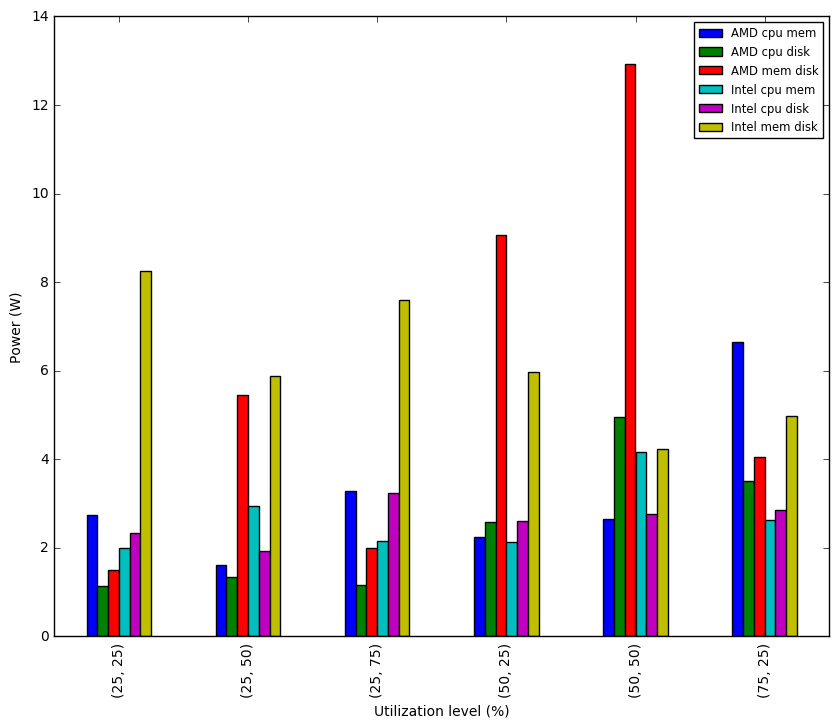

In [18]:
df_exe_energy_double_amd_pw_c1m2 = df_exe_energy_double_amd[df_exe_energy_double_amd['bkcod']=='c1m2']\
         .groupby(['ULx','ULy']).std().reset_index()
df_exe_energy_double_amd_pw_c1f1 = df_exe_energy_double_amd[df_exe_energy_double_amd['bkcod']=='c1f1']\
         .groupby(['ULx','ULy']).std().reset_index()
df_exe_energy_double_amd_pw_m2f1 = df_exe_energy_double_amd[df_exe_energy_double_amd['bkcod']=='m2f1']\
         .groupby(['ULx','ULy']).std().reset_index()    

df_exe_energy_double_intel_pw_c1m2 = df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1m2']\
         .groupby(['ULx','ULy']).std().reset_index()
df_exe_energy_double_intel_pw_c1f1 = df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1f1']\
         .groupby(['ULx','ULy']).std().reset_index()
df_exe_energy_double_intel_pw_m2f1 = df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='m2f1']\
         .groupby(['ULx','ULy']).std().reset_index()
   
df_result = pd.concat([\
                    df_exe_energy_double_amd_pw_c1m2,\
                       
                    df_exe_energy_double_amd_pw_c1f1['power_average'],\
                    df_exe_energy_double_amd_pw_m2f1['power_average'],\
                    
                       
                    df_exe_energy_double_intel_pw_c1m2['power_average'],\
                    df_exe_energy_double_intel_pw_c1f1['power_average'],\
                                           
                    df_exe_energy_double_intel_pw_m2f1['power_average'],\
                   ],axis=1)    
    

df_result.columns = ['ULx', 
                     'ULy', 
                    'AMD cpu mem',
                     'AMD cpu disk',
                     'AMD mem disk',
                     'Intel cpu mem',
                     'Intel cpu disk',
                     'Intel mem disk'
                    ]

display (df_result,'Energy-double')
aux = df_result.plot(x= ['ULx','ULy'],y=['AMD cpu mem', 'AMD cpu disk', 'AMD mem disk',\
                  'Intel cpu mem', 'Intel cpu disk', 'Intel mem disk'],kind='bar', figsize=(10, 8))


aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Power (W)")


### deviation triple

,UL,AMD cpu,AMD mem,AMD disk,Intel cpu,Intel mem,Intel disk
0,12.5,0.5,4.7,5.0,8.6,4.7,0.9
1,25.0,0.4,7.4,29.0,5.7,0.9,1.5
2,37.5,0.0,14.2,29.2,9.7,2.2,2.4
3,50.0,0.0,12.3,184.5,3.7,1.1,3.2
4,62.5,0.0,12.9,184.9,0.6,4.3,3.8
5,75.0,0.0,11.4,182.7,0.8,1.7,5.1
6,87.5,0.0,14.6,367.8,9.4,1.5,25.8
7,100.0,4.5,16.2,147.2,11.0,2.0,4.0


'Performance-single'

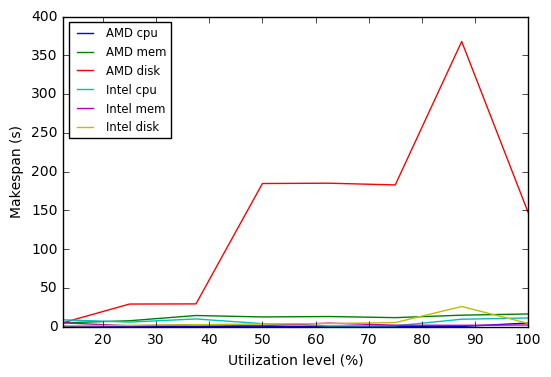

In [22]:
df_exe_performance_single_amd_pw_c1unt = df_exe_performance_single_amd[df_exe_performance_single_amd['codu']=='c1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).std().reset_index()

df_exe_performance_single_amd_pw_m2unt = df_exe_performance_single_amd[df_exe_performance_single_amd['codu']=='m2unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).std().reset_index()
    
df_exe_performance_single_amd_pw_f1unt = df_exe_performance_single_amd[df_exe_performance_single_amd['codu']=='f1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).std().reset_index() 
    
df_exe_performance_single_intel_pw_c1unt = df_exe_performance_single_intel[df_exe_performance_single_intel['codu']=='c1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).std().reset_index()

df_exe_performance_single_intel_pw_m2unt = df_exe_performance_single_intel[df_exe_performance_single_intel['codu']=='m2unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).std().reset_index()
    
df_exe_performance_single_intel_pw_f1unt = df_exe_performance_single_intel[df_exe_performance_single_intel['codu']=='f1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).std().reset_index()
    
    
df_result = pd.concat([df_exe_performance_single_amd_pw_c1unt,\
                    df_exe_performance_single_amd_pw_m2unt['seconds'],\
                    df_exe_performance_single_amd_pw_f1unt['seconds'],\
                   df_exe_performance_single_intel_pw_c1unt['seconds'],\
                    df_exe_performance_single_intel_pw_m2unt['seconds'],\
                    df_exe_performance_single_intel_pw_f1unt['seconds']],\
                  axis=1)    


df_result.columns = ['UL', 'AMD cpu', 'AMD mem', 'AMD disk', 'Intel cpu', 'Intel mem', 'Intel disk']
display (df_result,'Performance-single')

aux=df_result.plot(x= ['UL'],y=['AMD cpu', 'AMD mem', 'AMD disk', 'Intel cpu',\
                                         'Intel mem', 'Intel disk'])

aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Makespan (s)")


In [56]:
### iqr calculation example

In [47]:
CPU100 = df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l100']
iqr = CPU100["power_average"].quantile(0.75) - CPU100["power_average"].quantile(0.25)
display(iqr)

1.6908563134977612